In [203]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


from pandas.plotting import scatter_matrix
from scipy.stats import gaussian_kde
import warnings
warnings.filterwarnings('ignore')

from inspect import isclass, signature
import os
from woodwork.logical_types import Boolean, BooleanNullable

In [204]:
train_features = pd.read_csv('/kaggle/input/train.csv')
train_labels = pd.read_csv('/kaggle/input/target.csv')
test_features = pd.read_csv('/kaggle/input/test.csv')
id_test = test_features['ID']
train_features.columns = train_features.columns.str.replace(r'[{}"\':,]', '_', regex=True)
test_features.columns = test_features.columns.str.replace(r'[{}"\':,]', '_', regex=True)

In [205]:
# Melihat struktur data
print("Ukuran data train features:", train_features.shape)
print("Ukuran data train labels:", train_labels.shape)
print("Ukuran data test features:", test_features.shape)

Ukuran data train features: (7000, 16)
Ukuran data train labels: (7000, 1)
Ukuran data test features: (3000, 17)


In [206]:
# Melihat beberapa baris pertama dari data
train_features.describe()

,userRatingCount,isCorporateEmailScore,adSpent,appAge,averageUserRating
count,7.000000e+03,5872.000000,1.321000e+03,6950.000000,5768.000000
mean,3.256274e+04,45.740293,3.977563e+03,57.093060,2.482490
std,5.501431e+05,49.361215,9.219919e+04,37.169895,1.905712
min,0.000000e+00,0.000000,7.038525e-03,0.533333,0.000000
25%,0.000000e+00,0.000000,1.086920e+00,27.533333,0.000000
50%,1.000000e+00,0.000000,7.945580e+00,52.866667,3.000000
75%,8.800000e+01,99.000000,4.908375e+01,80.000000,4.000000
max,3.854334e+07,99.000000,3.143906e+06,196.466667,5.000000


In [139]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   developerCountry                 7000 non-null   object 
 1   countryCode                      6936 non-null   object 
 2   userRatingCount                  7000 non-null   int64  
 3   primaryGenreName                 7000 non-null   object 
 4   downloads                        4851 non-null   object 
 5   deviceType                       7000 non-null   object 
 6   hasPrivacyLink                   6250 non-null   object 
 7   hasTermsOfServiceLink            2365 non-null   object 
 8   hasTermsOfServiceLinkRating      2365 non-null   object 
 9   isCorporateEmailScore            5872 non-null   float64
 10  adSpent                          1321 non-null   float64
 11  appAge                           6950 non-null   float64
 12  averageUserRating   

In [140]:
with pd.option_context('display.max_rows', None):
    print(train_features['appDescriptionBrandSafetyRating'].value_counts())

appDescriptionBrandSafetyRating
low       5652
medium     754
high       594
Name: count, dtype: int64


In [141]:
# Melihat beberapa baris pertama dari data
# test_features['appAge'] += 1.2
test_features.describe()

,ID,userRatingCount,isCorporateEmailScore,adSpent,appAge,averageUserRating
count,3000.000000,3.000000e+03,2560.000000,574.000000,2983.000000,2486.000000
mean,5016.298333,3.576905e+04,46.444922,286.612276,56.044396,2.490748
std,2894.991128,4.455556e+05,49.415285,1890.997697,36.417410,1.896230
min,1.000000,0.000000e+00,0.000000,0.007450,-1.200000,0.000000
25%,2495.750000,0.000000e+00,0.000000,1.121507,26.933333,0.000000
50%,4969.500000,1.000000e+00,0.000000,7.186537,51.933333,3.000000
75%,7585.500000,8.250000e+01,99.000000,44.878463,77.750000,4.000000
max,9999.000000,1.319941e+07,99.000000,37542.779693,194.466667,5.000000


In [142]:
print("\nSampel data train labels:")
print(train_labels.head())


Sampel data train labels:
   coppaRisk
0      False
1      False
2      False
3      False
4      False


In [143]:
train_features['downloads'].unique()

array([nan, '50 - 100', '50000000 - 100000000', '1000 - 5000', '1 - 5',
       '100 - 500', '10000 - 50000', '50000 - 100000', '10 - 50',
       '5 - 10', '100000 - 500000', '5000 - 10000', '500 - 1000',
       '1000000 - 5000000', '0 - 1', '10000000 - 50000000',
       '500000 - 1000000', '1 - 1', '5000000 - 10000000', '10 - 1',
       '100000000 - 500000000', '5 - 1', '10000000000 - 15000000000',
       '500 - 1', '500000000 - 1000000000', '1000000000 - 5000000000',
       '50 - 1'], dtype=object)

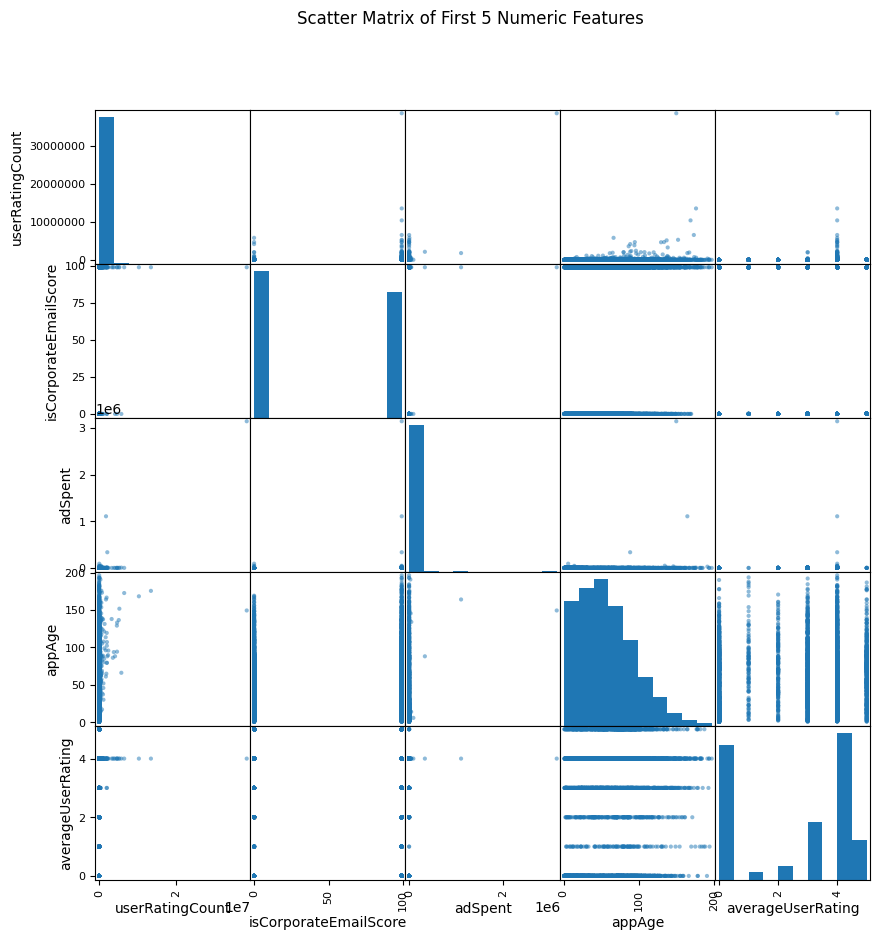

In [144]:
# Identify numeric and categorical features
numerics = train_features.select_dtypes(include=[np.number]).columns.tolist()
if 'coppaRisk' in numerics:
    numerics.remove('coppaRisk')
categoricals = train_features.select_dtypes(include=['object']).columns.tolist()
# 5.2 Scatter Matrix for first 5 numeric features (hist diagonal) to avoid KDE issues
subset = numerics[:5]
scatter_matrix(train_features[subset], figsize=(10,10), diagonal='hist')
plt.suptitle('Scatter Matrix of First 5 Numeric Features')
plt.savefig('scatter_matrix.png')  # Menyimpan sebagai file PNG
plt.show()

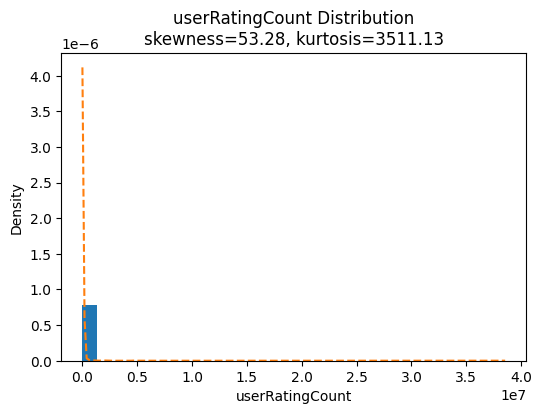

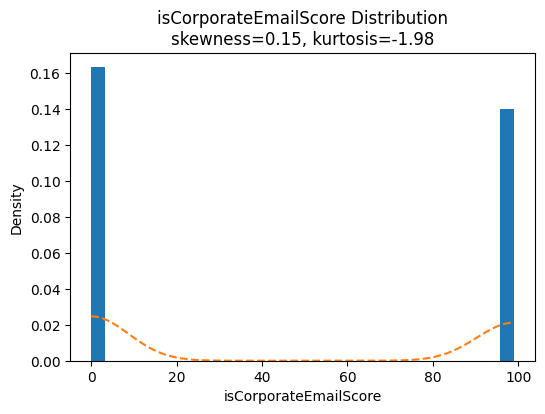

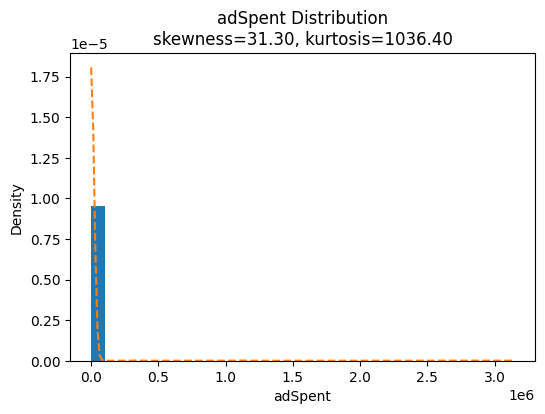

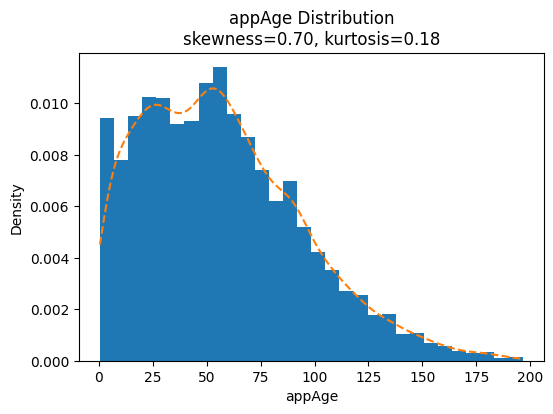

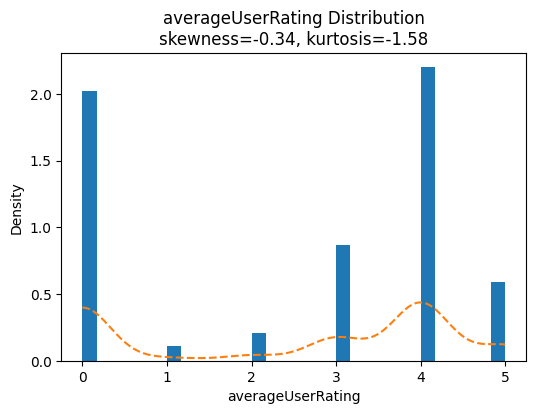

In [145]:
# 1. Distribution Analysis: Histogram & Density Plot with skewness & kurtosis
for col in numerics:
    data = train_features[col].dropna().astype(float)
    skew = data.skew()
    kurt = data.kurtosis()
    xs = np.linspace(data.min(), data.max(), 200)
    kde = gaussian_kde(data)
    
    plt.figure(figsize=(6,4))
    plt.hist(data, bins=30, density=True)
    plt.plot(xs, kde(xs), linestyle='--')
    plt.title(f'{col} Distribution\nskewness={skew:.2f}, kurtosis={kurt:.2f}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.savefig(f'hist_density_{col}.png')
    plt.show()

In [146]:
# 8. Skewness & Kurtosis Summary Table
stats = pd.DataFrame({
    'skewness': train_features[numerics].skew(),
    'kurtosis': train_features[numerics].kurtosis()
})
print(stats)

                        skewness     kurtosis
userRatingCount        53.284682  3511.130959
isCorporateEmailScore   0.152386    -1.977452
adSpent                31.303509  1036.403410
appAge                  0.703034     0.180696
averageUserRating      -0.337420    -1.575238


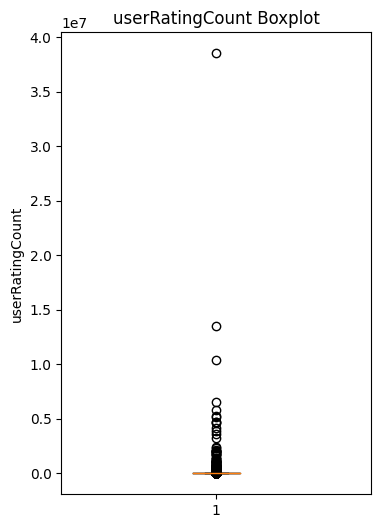

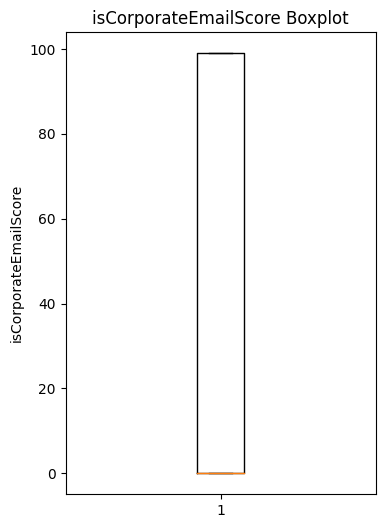

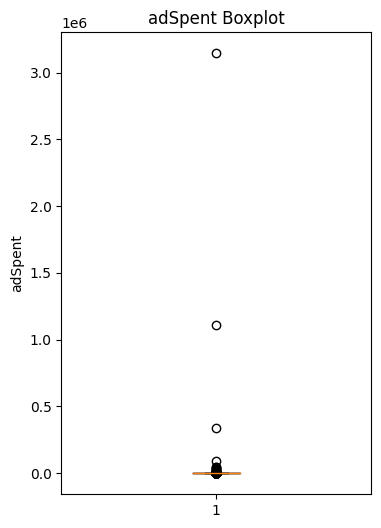

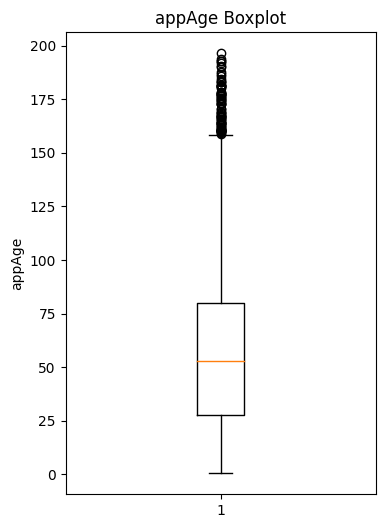

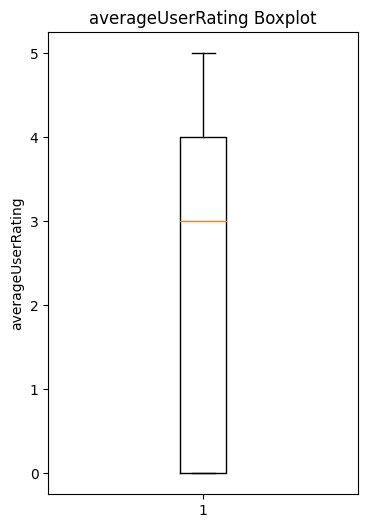

In [147]:
# 2. Outlier Detection: Box Plot per numeric feature
for col in numerics:
    data = train_features[col].dropna()
    plt.figure(figsize=(4,6))
    plt.boxplot(data, vert=True)
    plt.title(f'{col} Boxplot')
    plt.ylabel(col)
    plt.savefig(f'boxplot_{col}.png')
    plt.show()

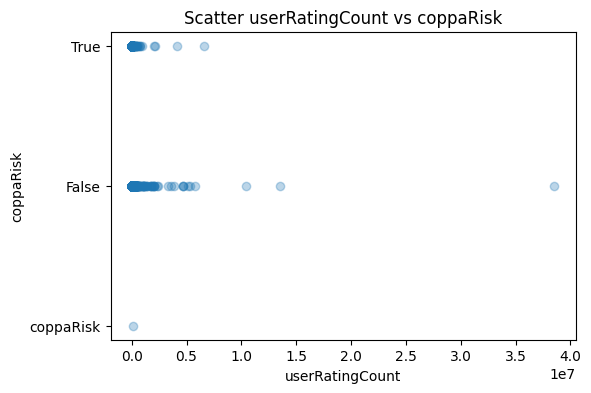

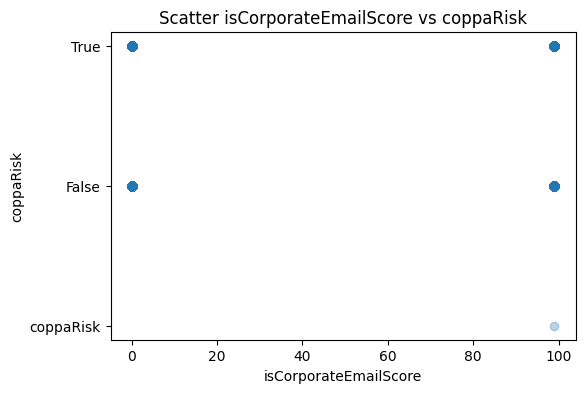

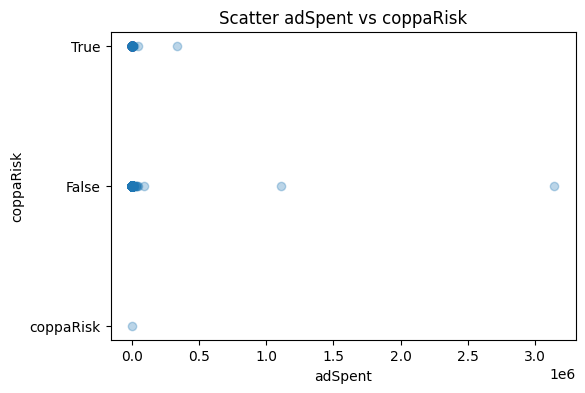

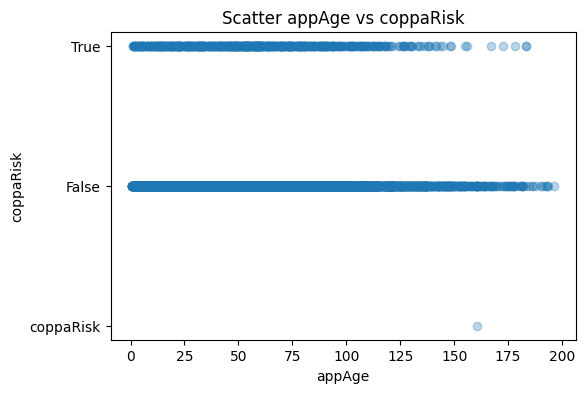

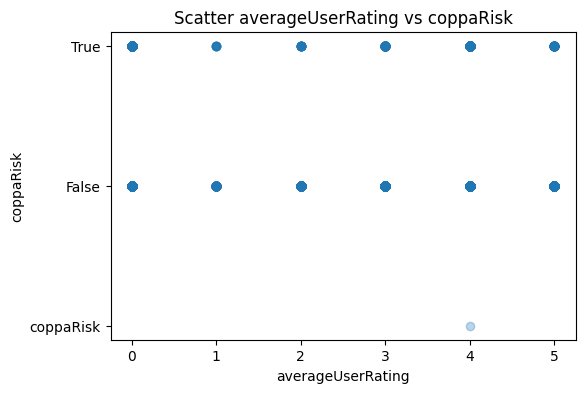

In [148]:
# 2.2 Scatter Plot vs Target
for col in numerics:
    plt.figure(figsize=(6,4))
    plt.scatter(train_features[col], df['coppaRisk'], alpha=0.3)
    plt.xlabel(col)
    plt.ylabel('coppaRisk')
    plt.title(f'Scatter {col} vs coppaRisk')
    plt.savefig(f'scatter_{col}_vs_target.png')
    plt.show()

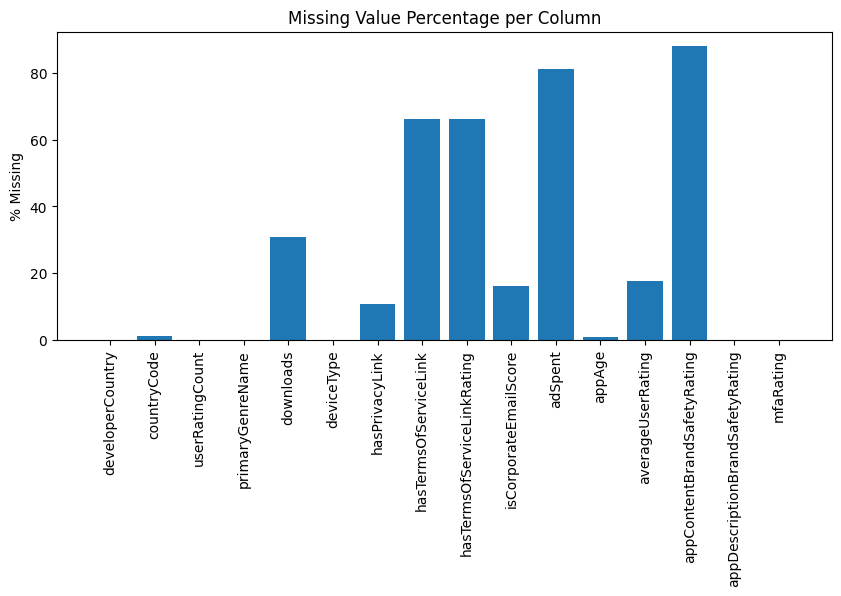

In [149]:
# 3. Missing Value Analysis: Bar Chart and Heatmap
missing_pct = train_features.isnull().mean() * 100
plt.figure(figsize=(10,4))
plt.bar(missing_pct.index, missing_pct.values)
plt.xticks(rotation=90)
plt.title('Missing Value Percentage per Column')
plt.ylabel('% Missing')
plt.savefig(f'missing_value.png')
plt.show()

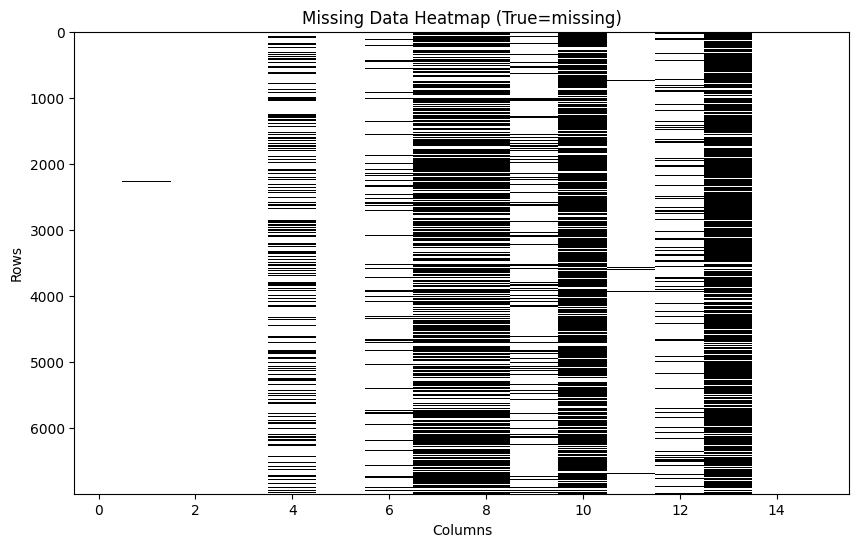

In [150]:
plt.figure(figsize=(10,6))
plt.imshow(train_features.isnull(), aspect='auto', interpolation='none', cmap='gray_r')
plt.title('Missing Data Heatmap (True=missing)')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.savefig(f'missing_heatmap.png')
plt.show()

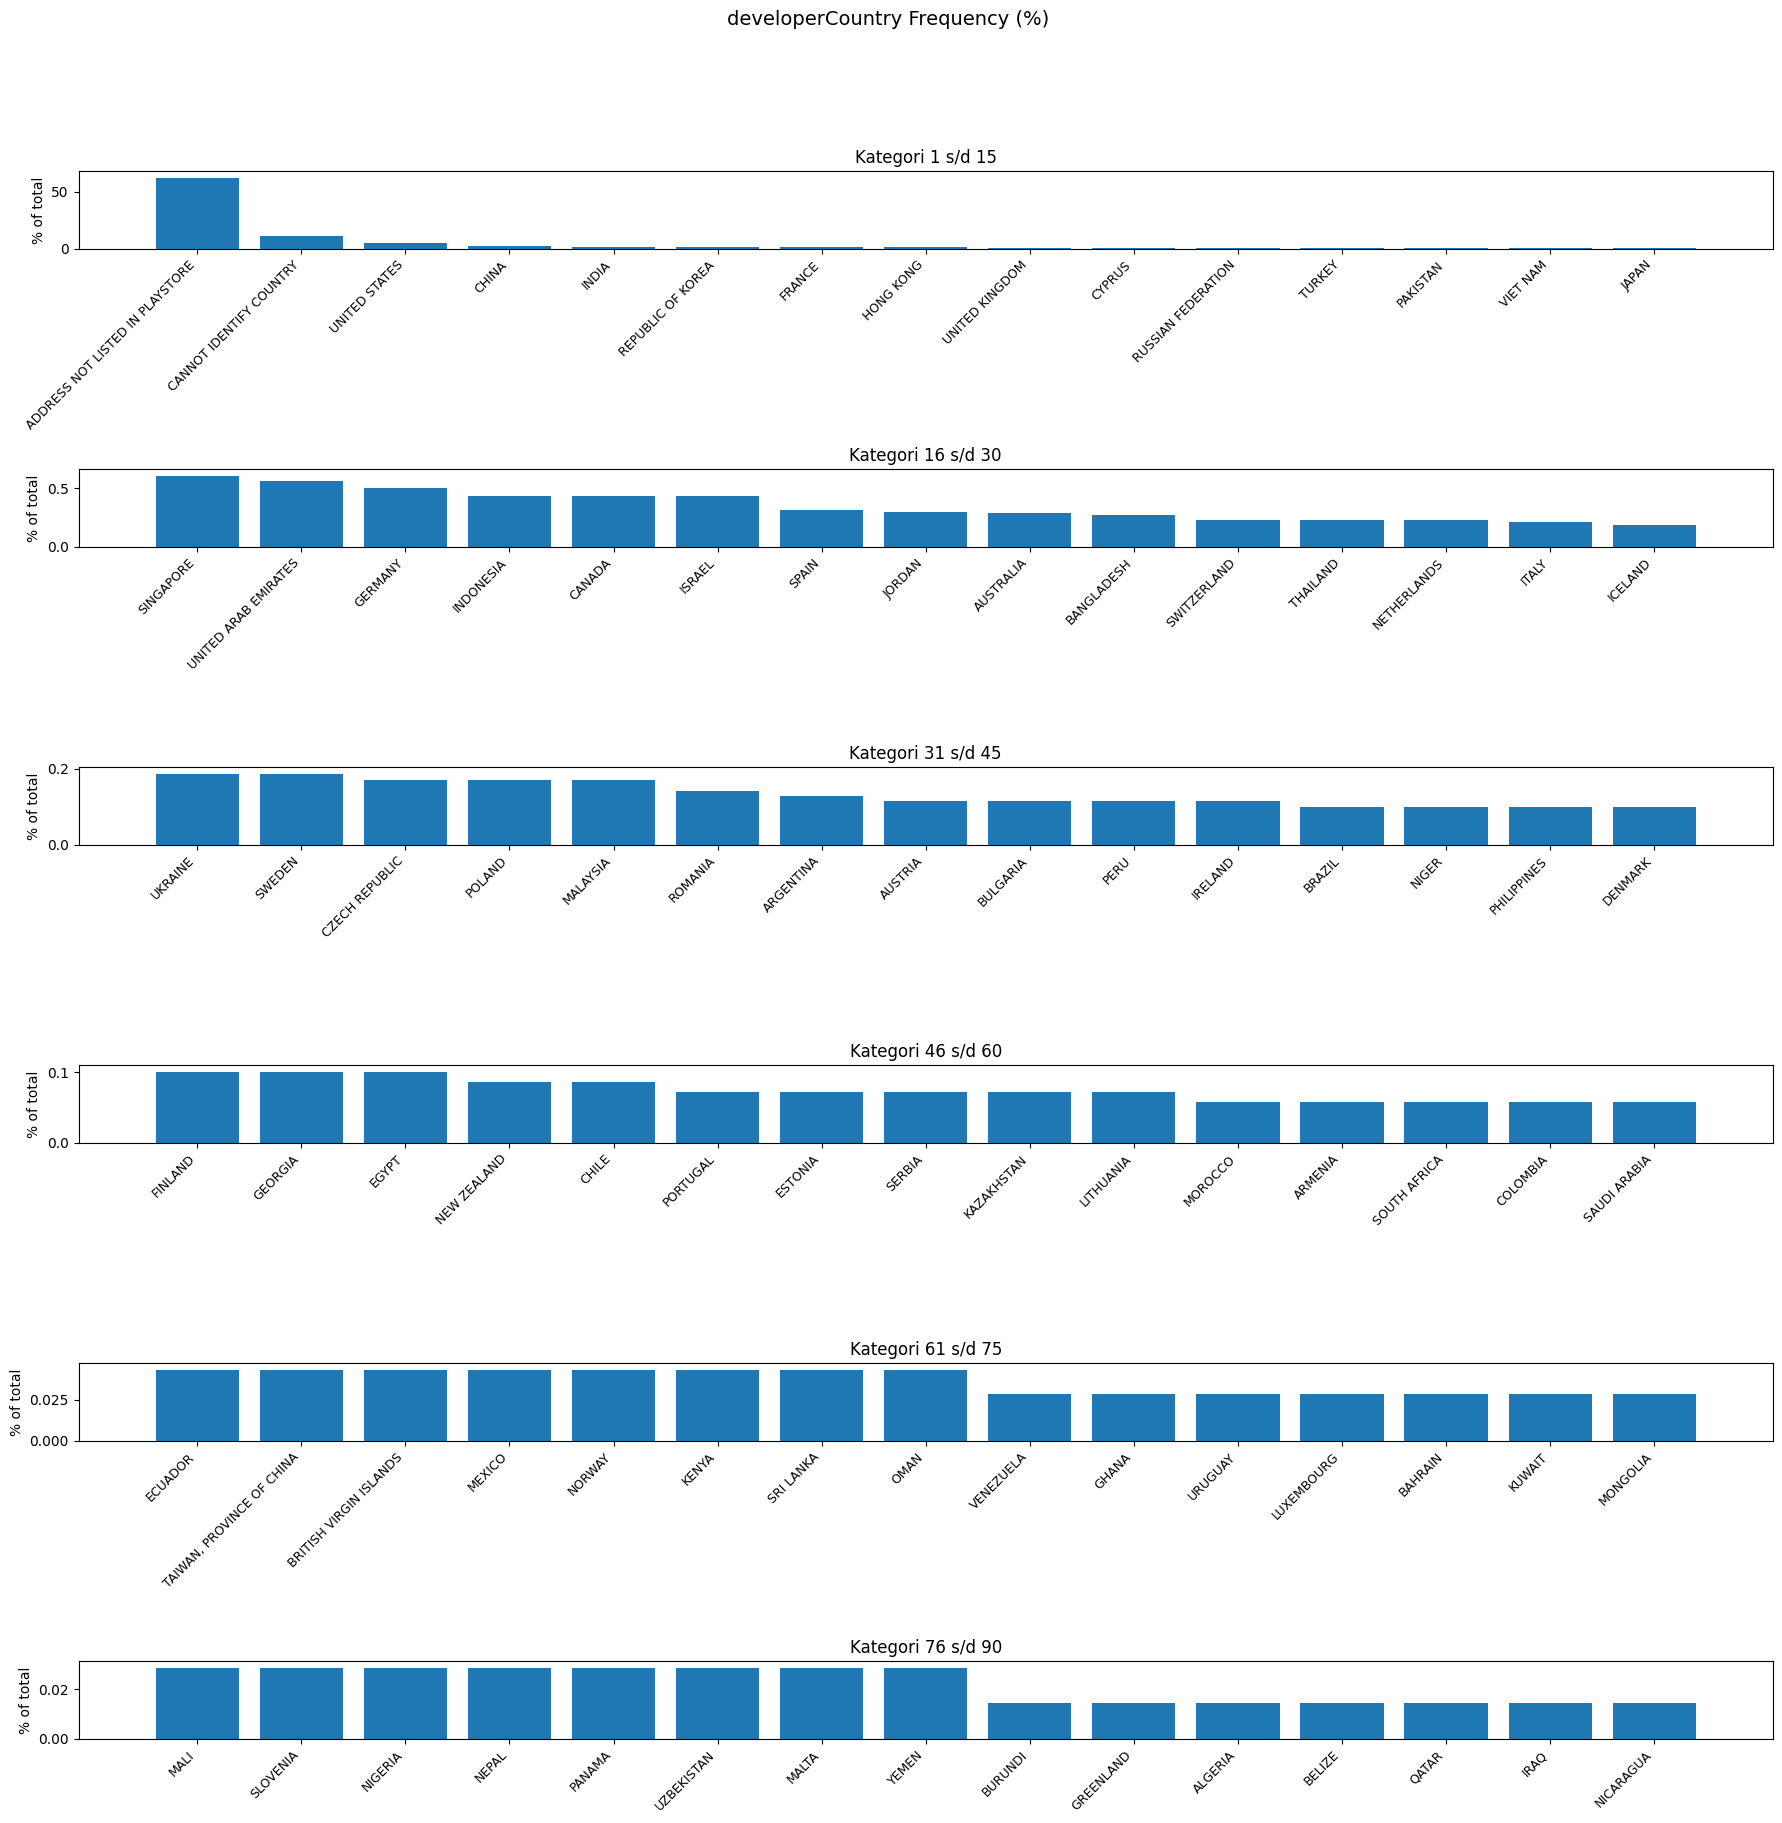

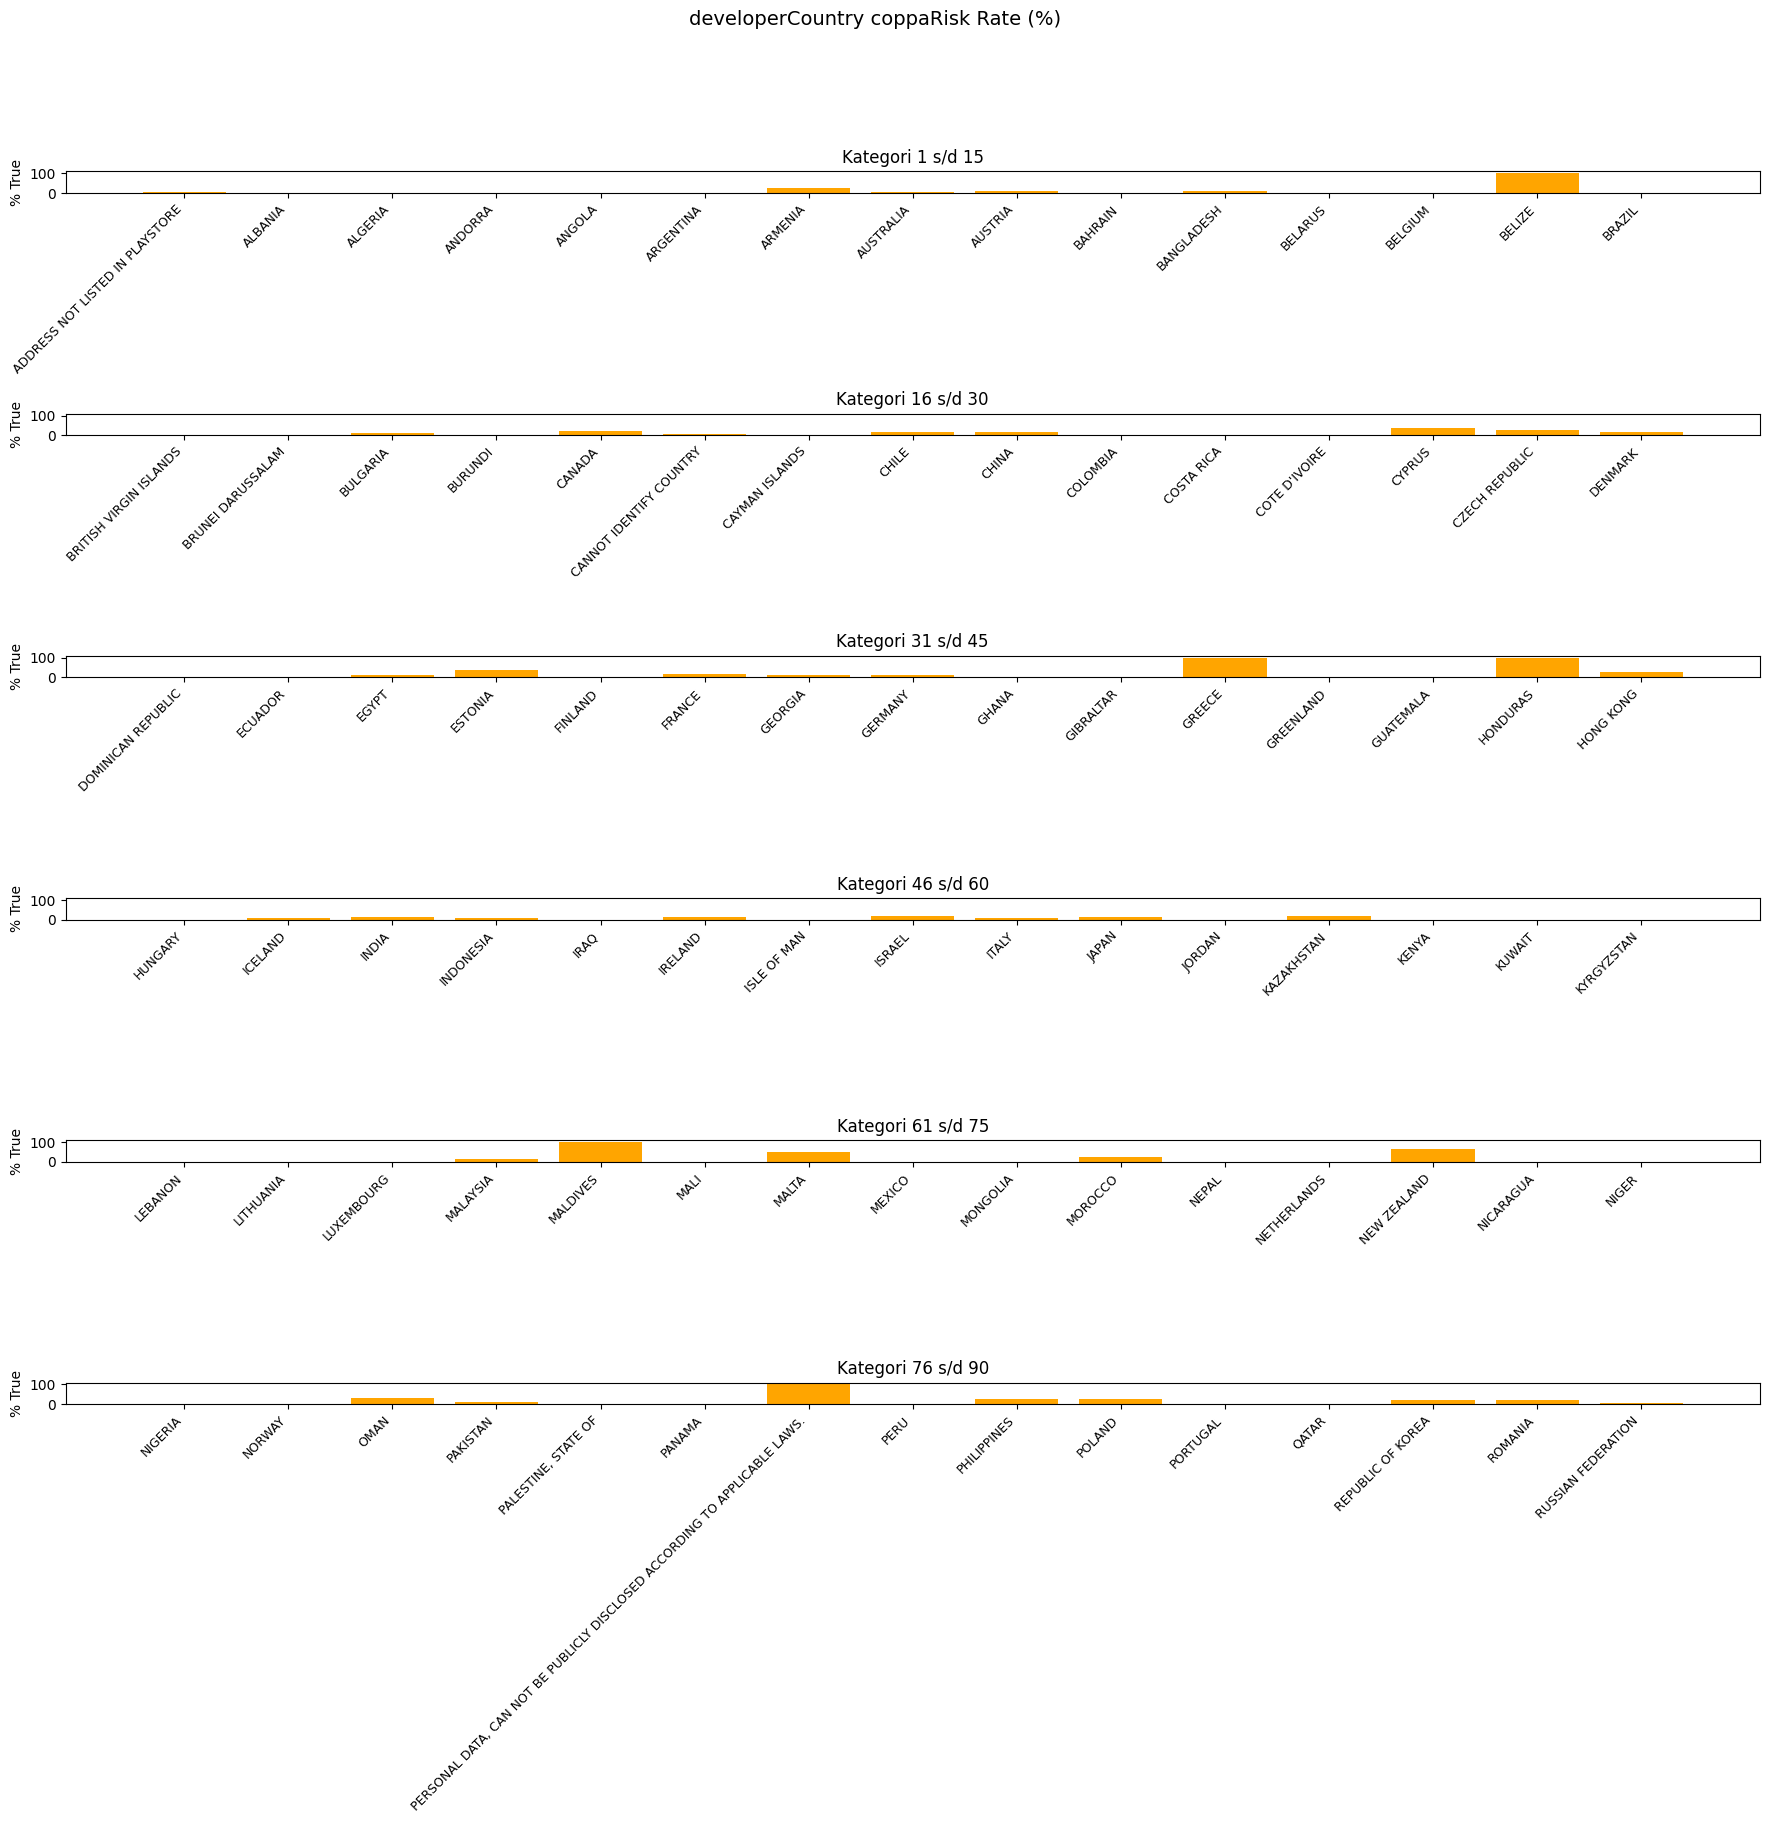

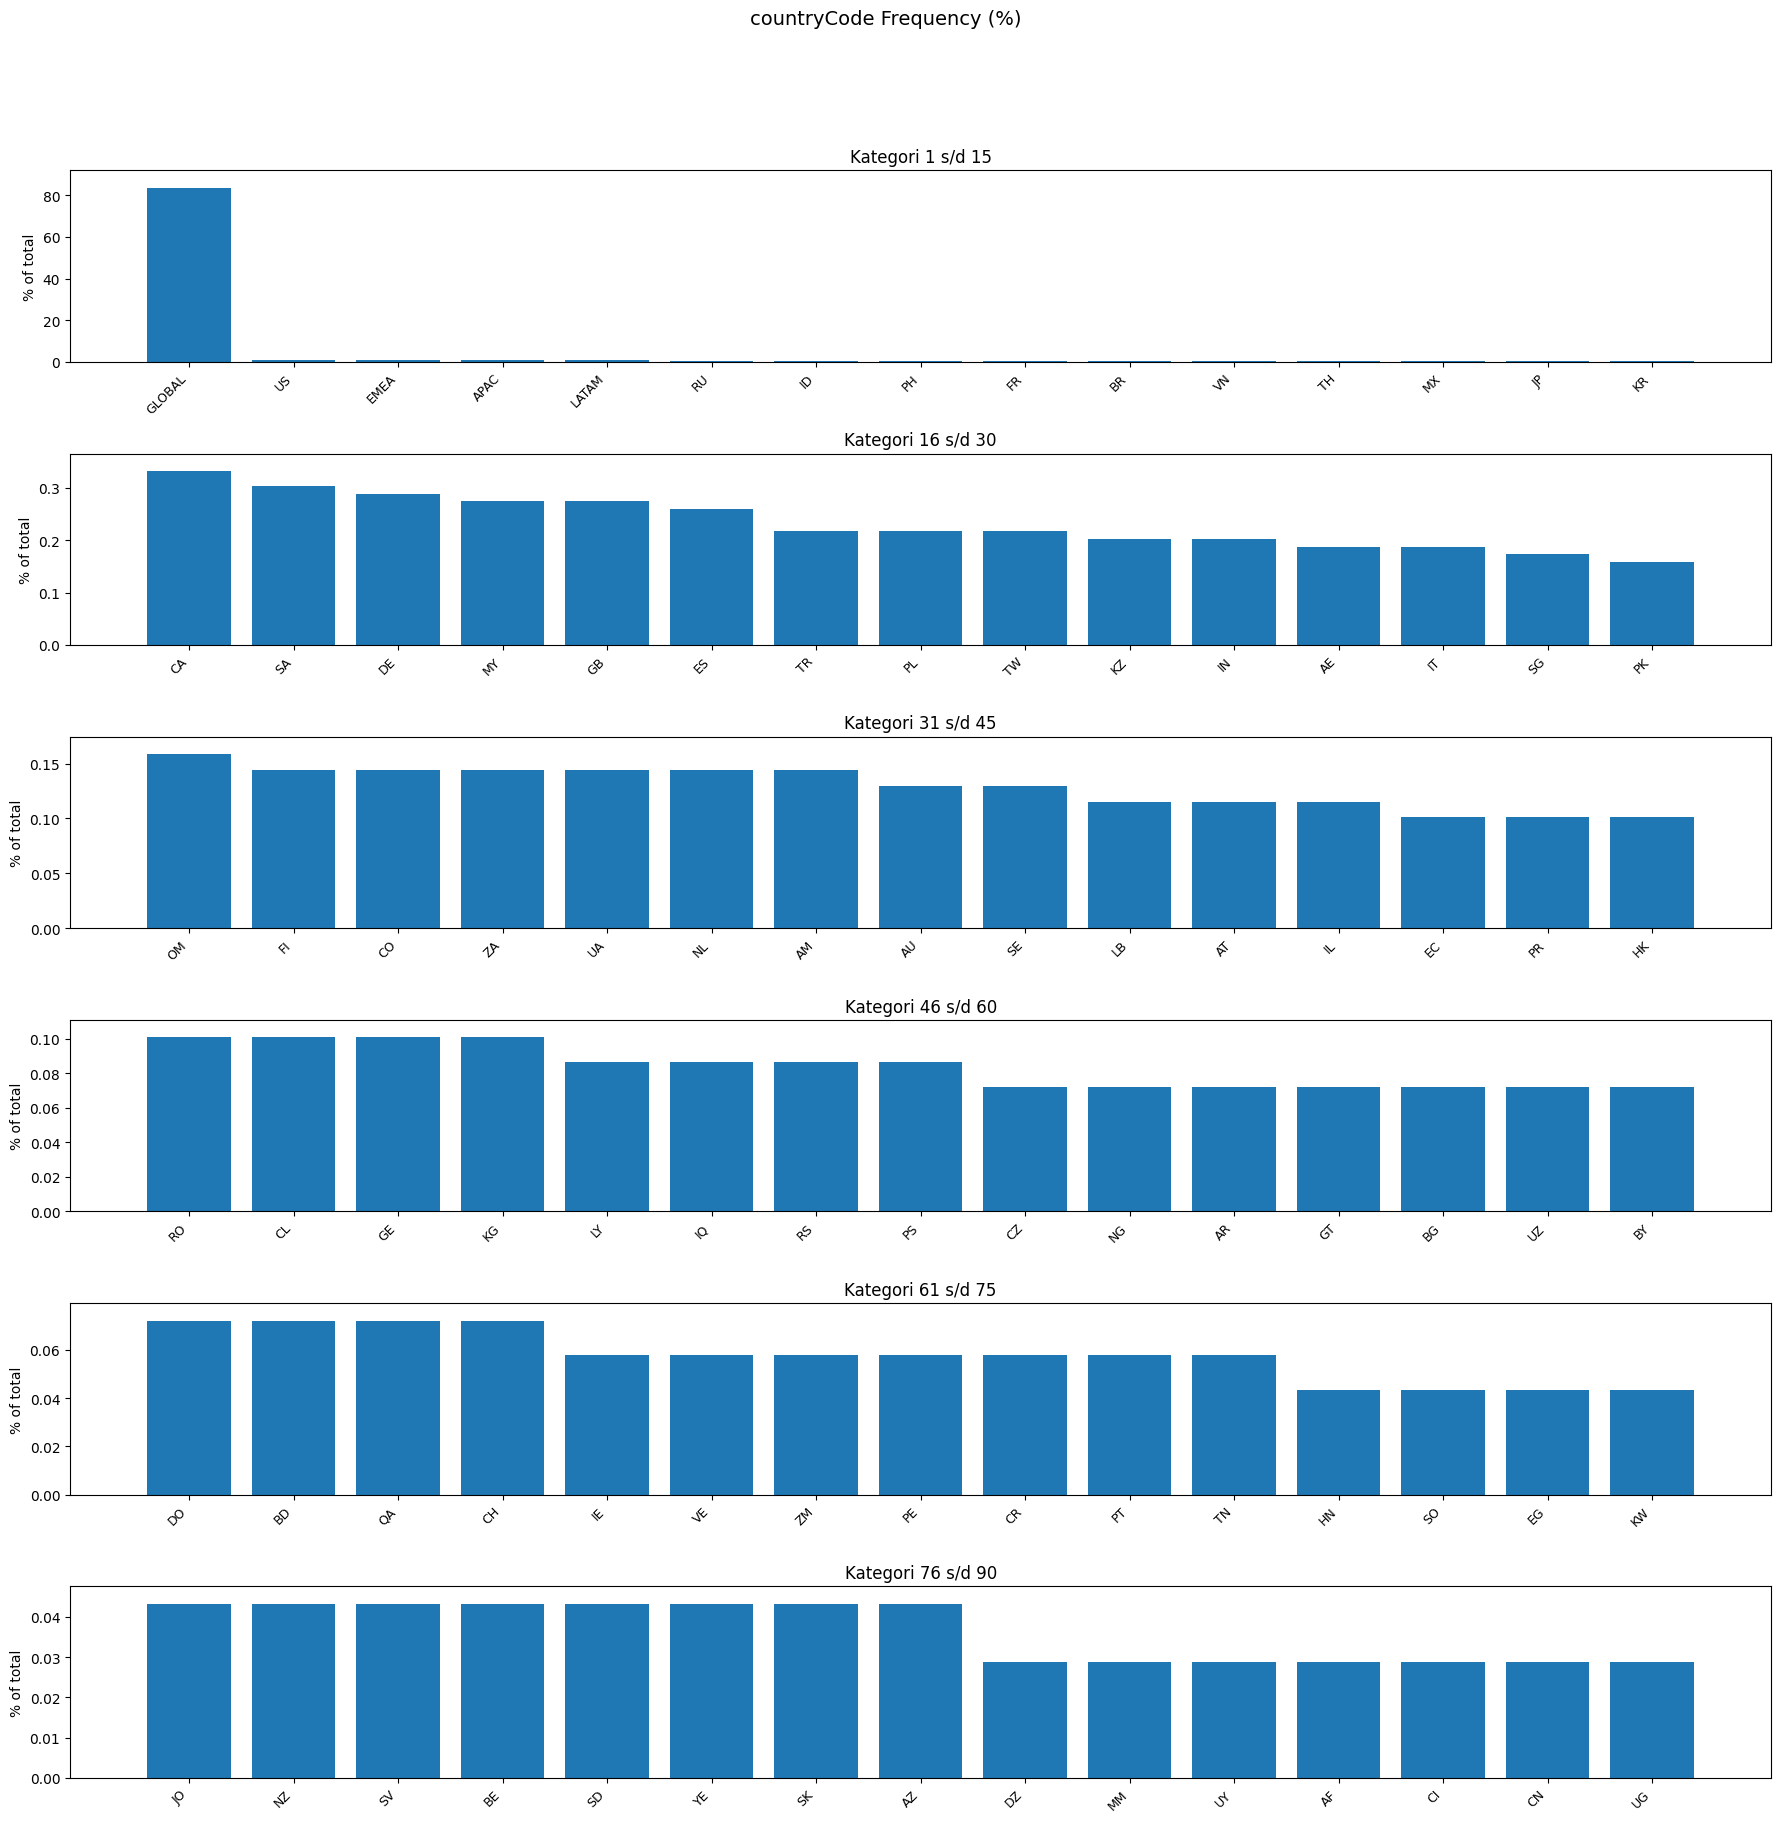

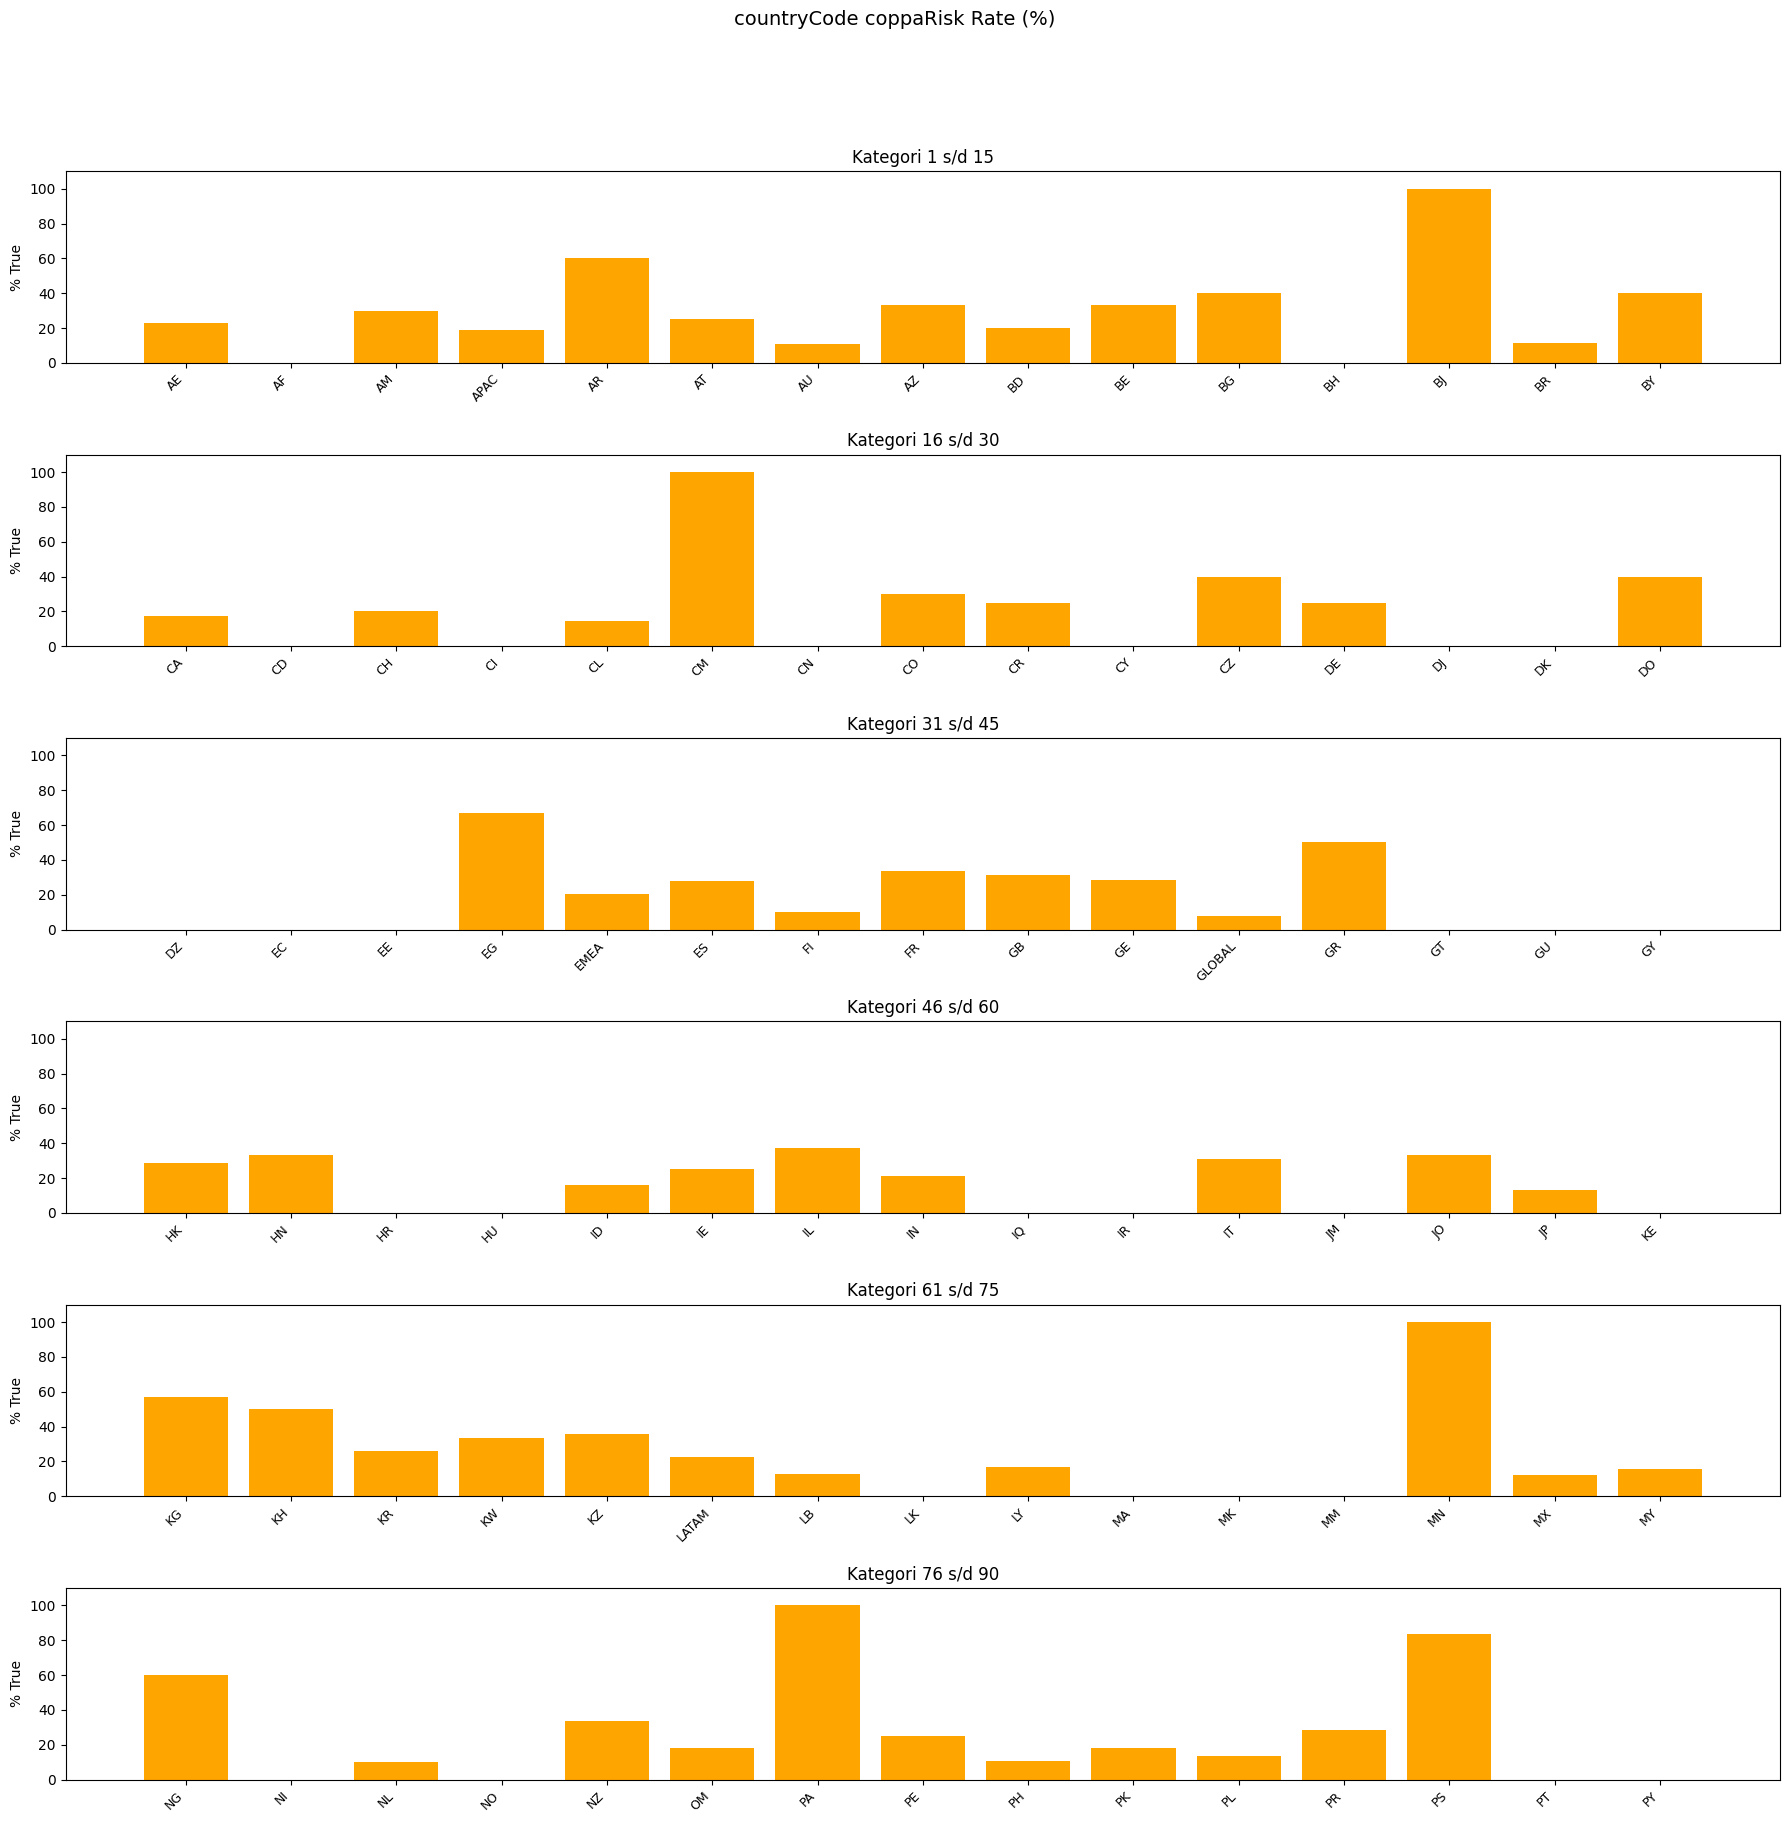

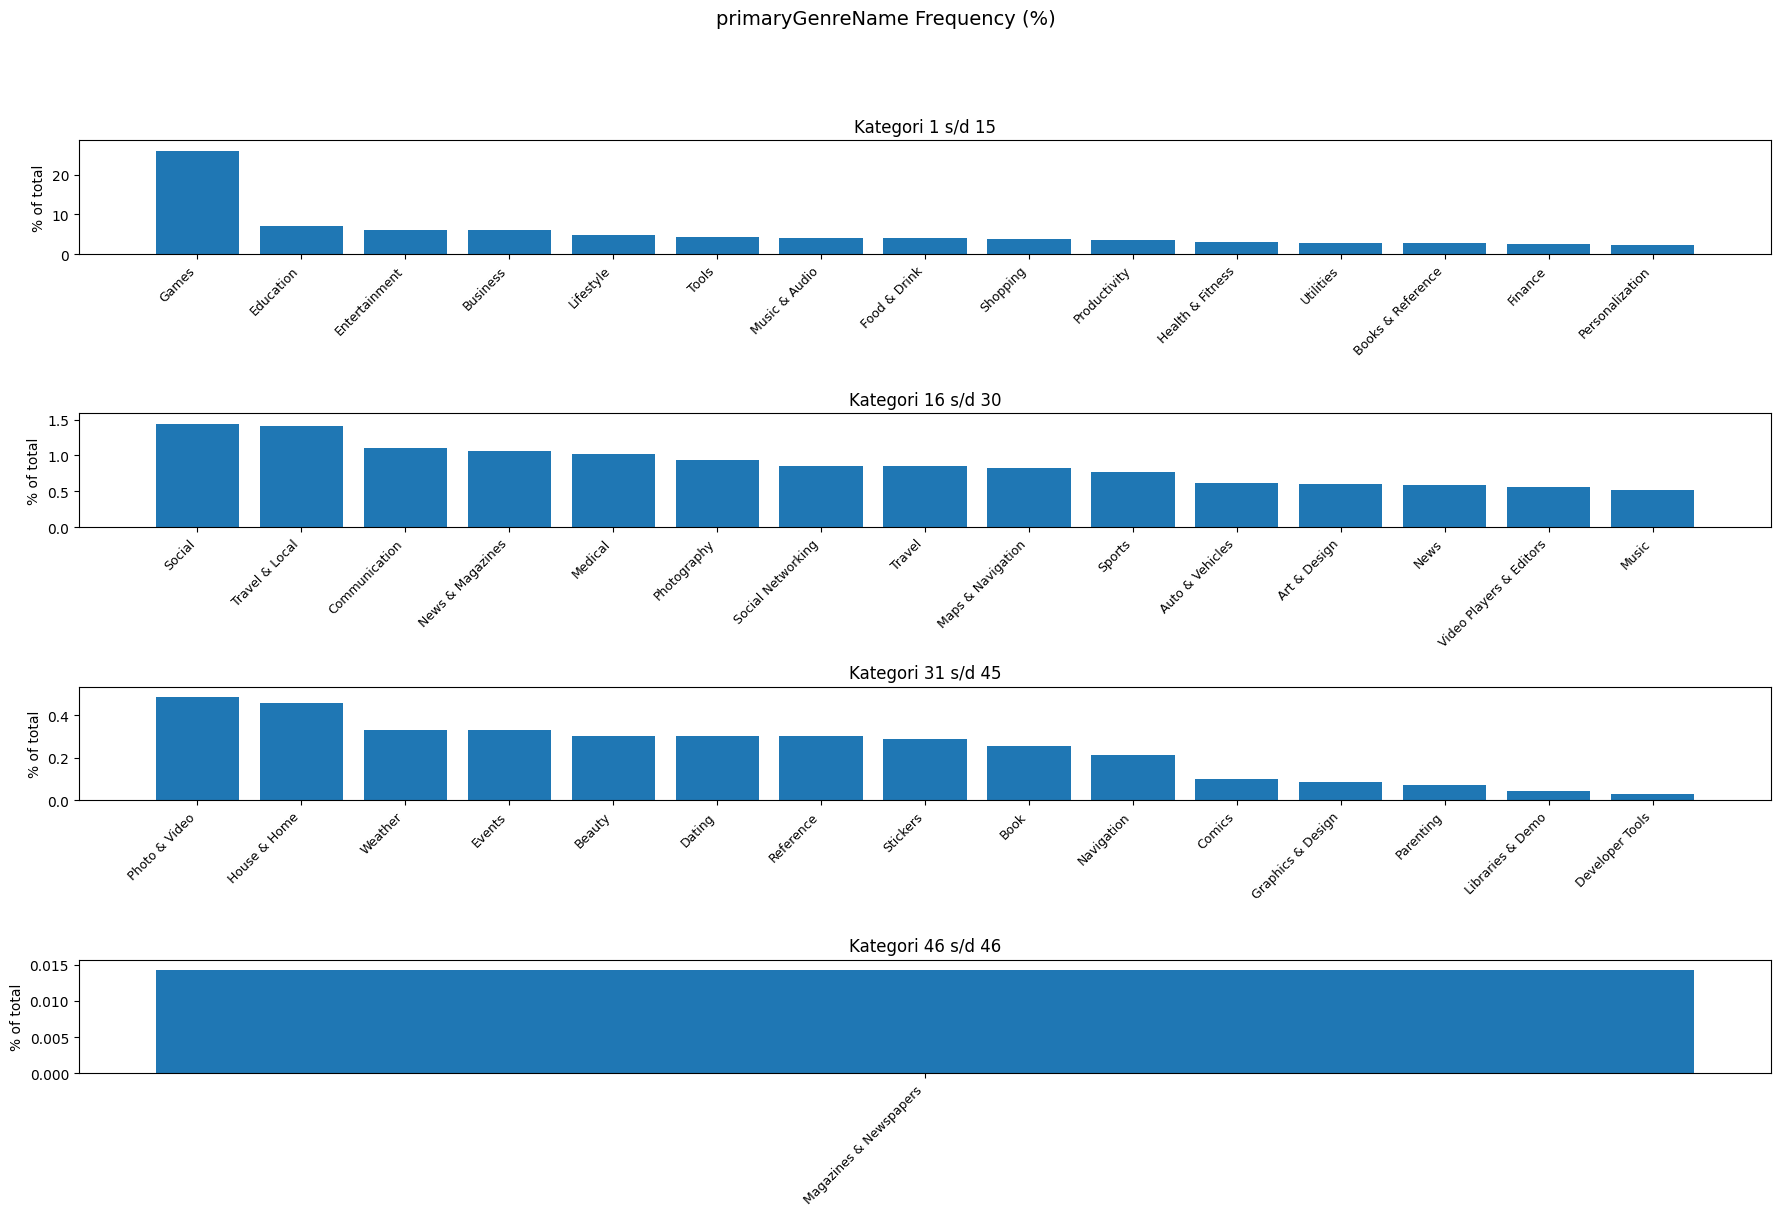

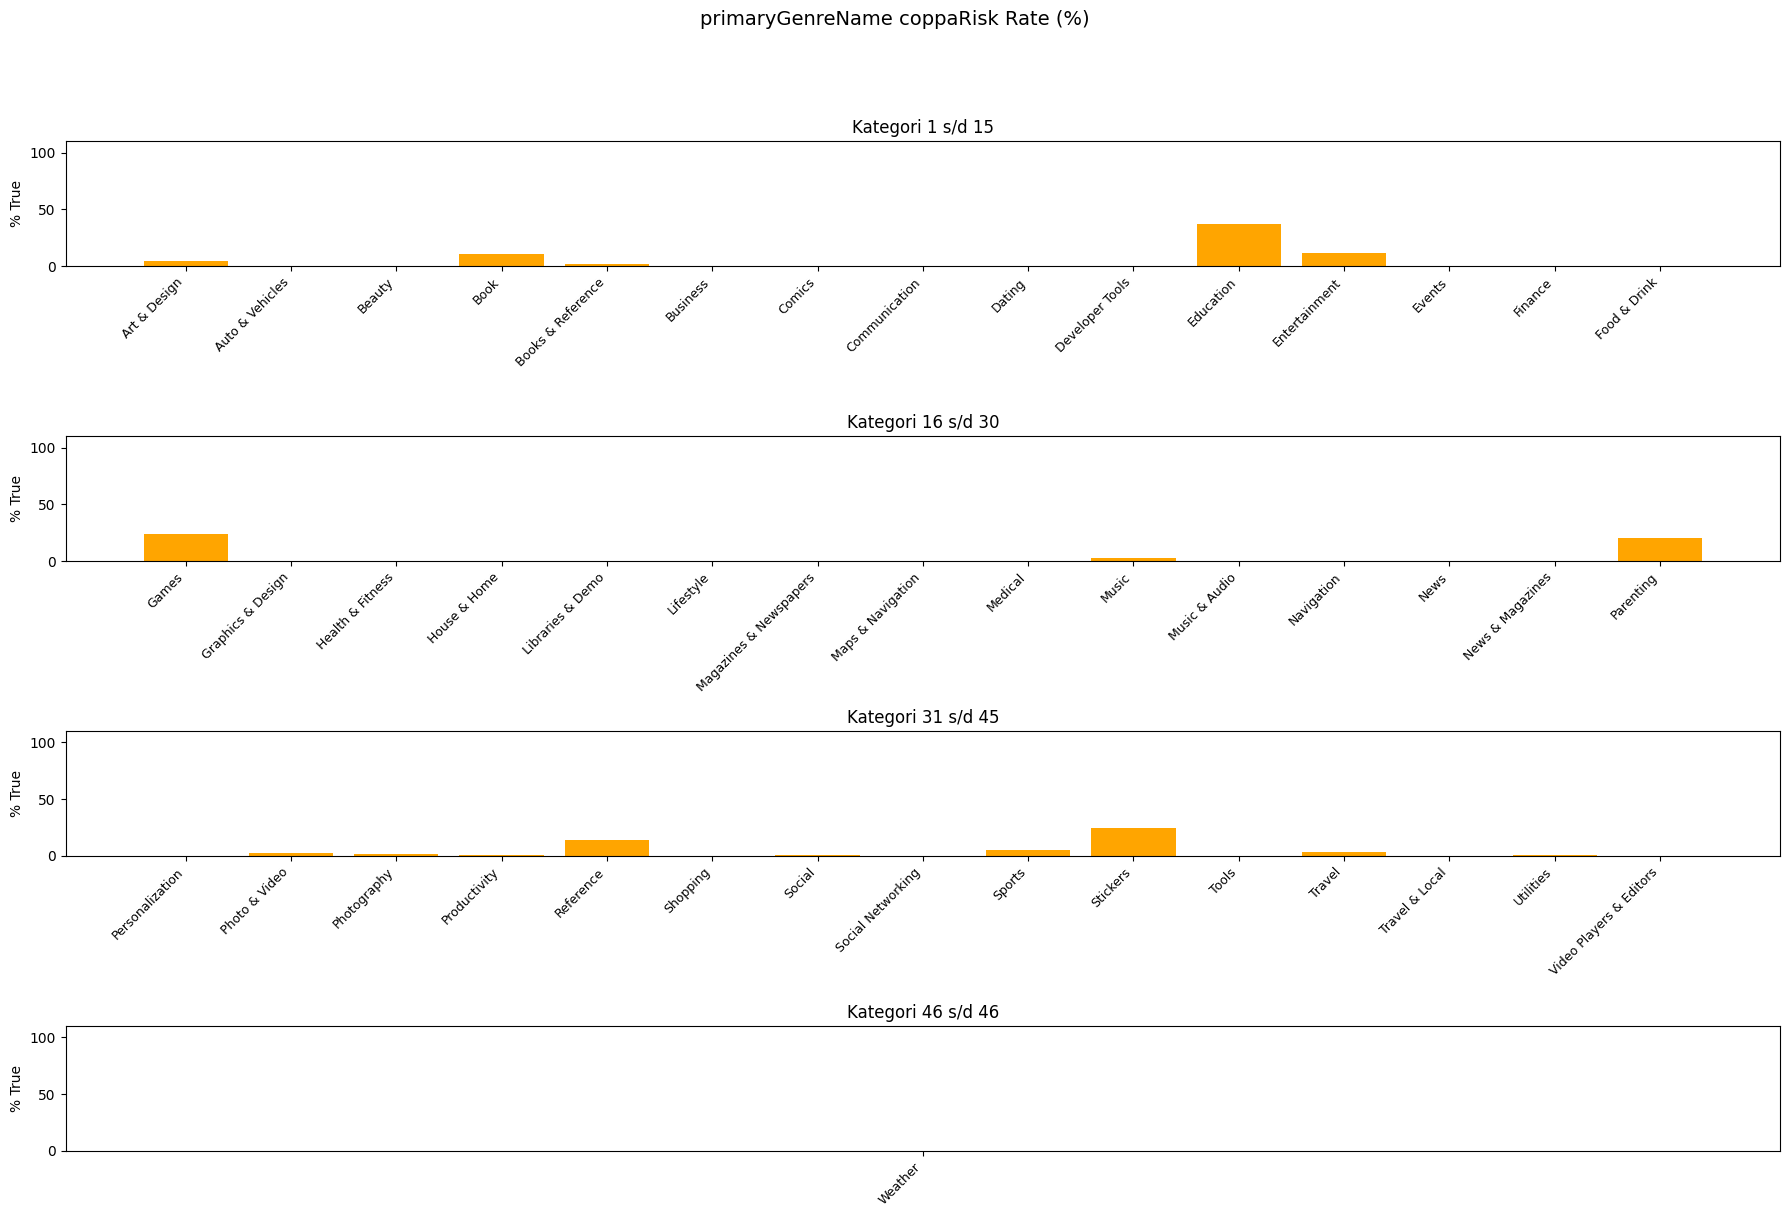

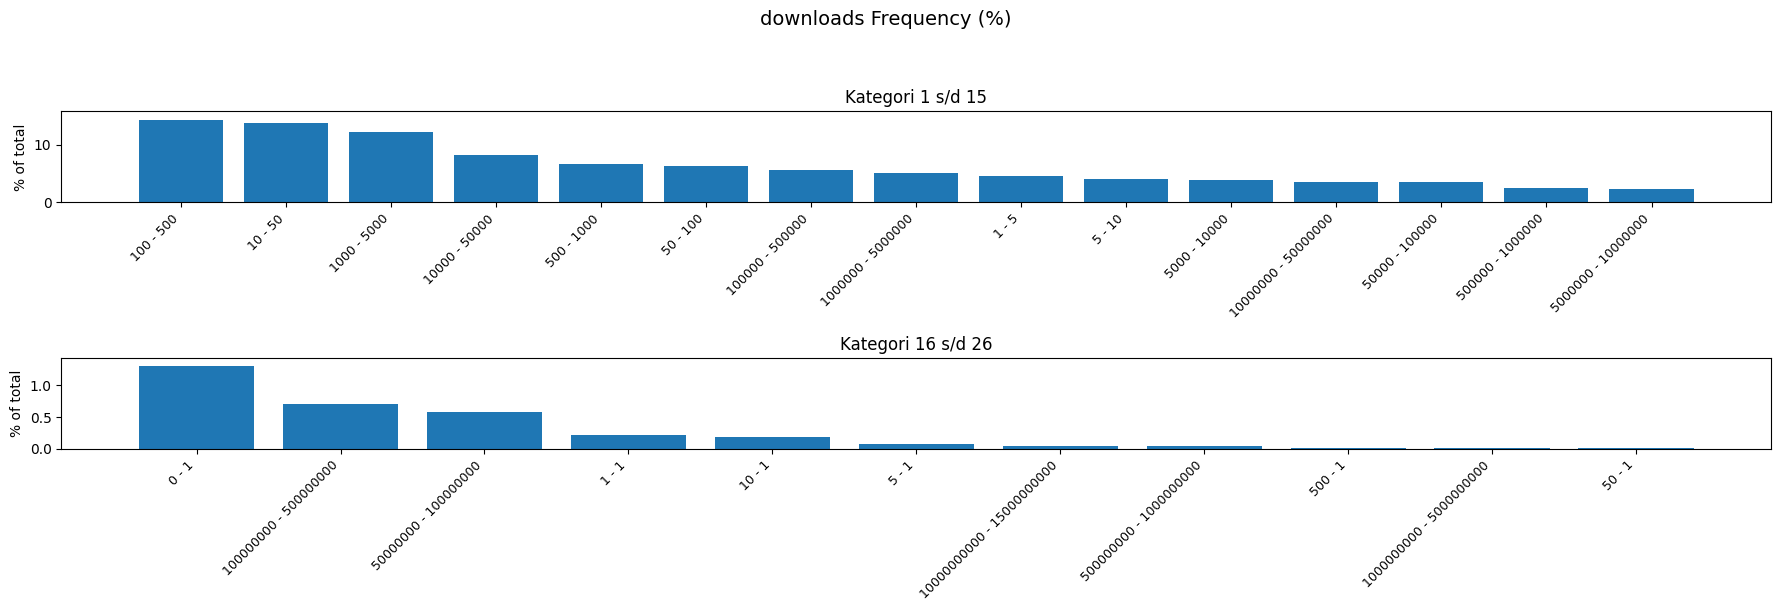

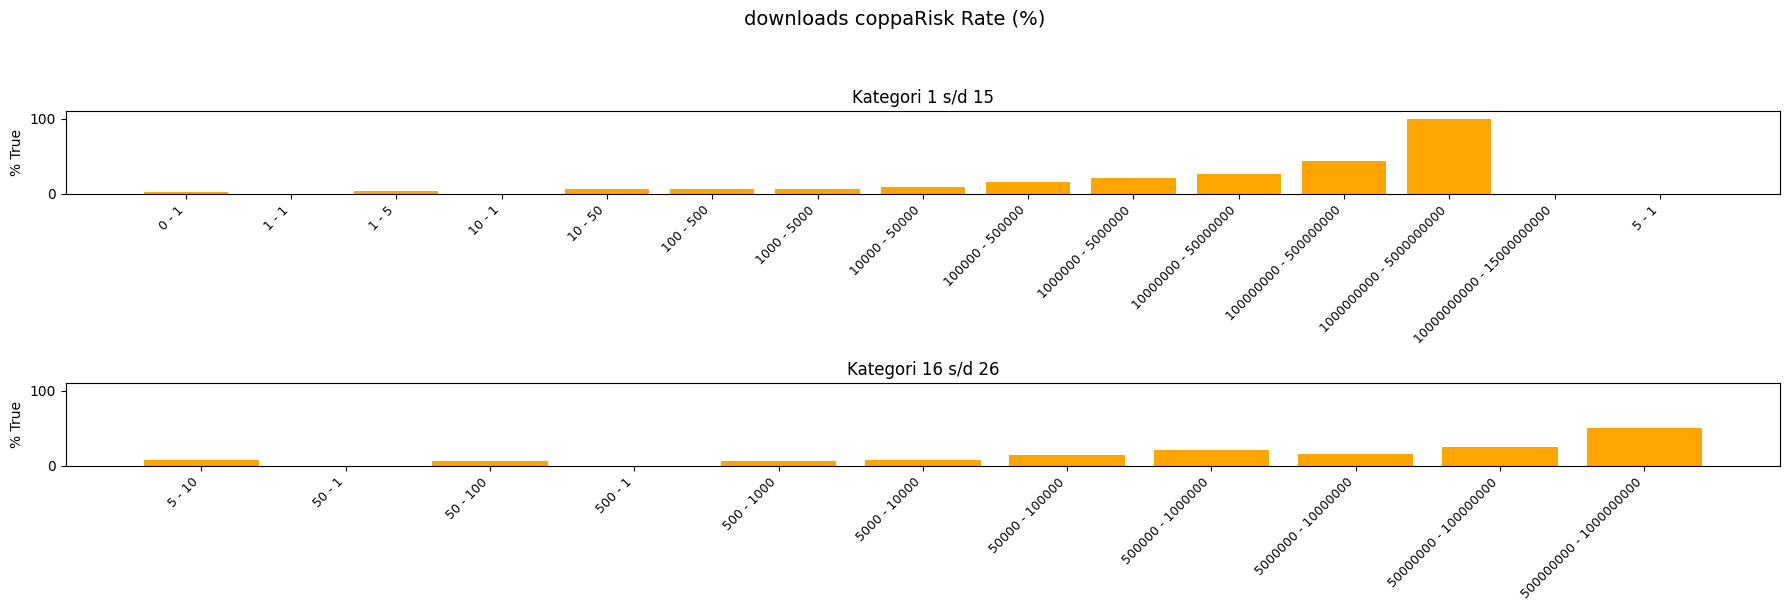

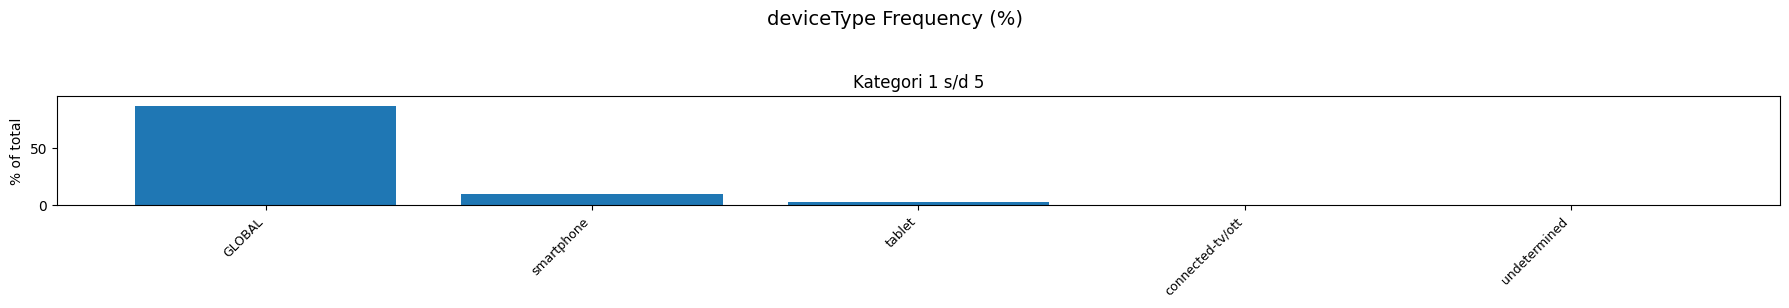

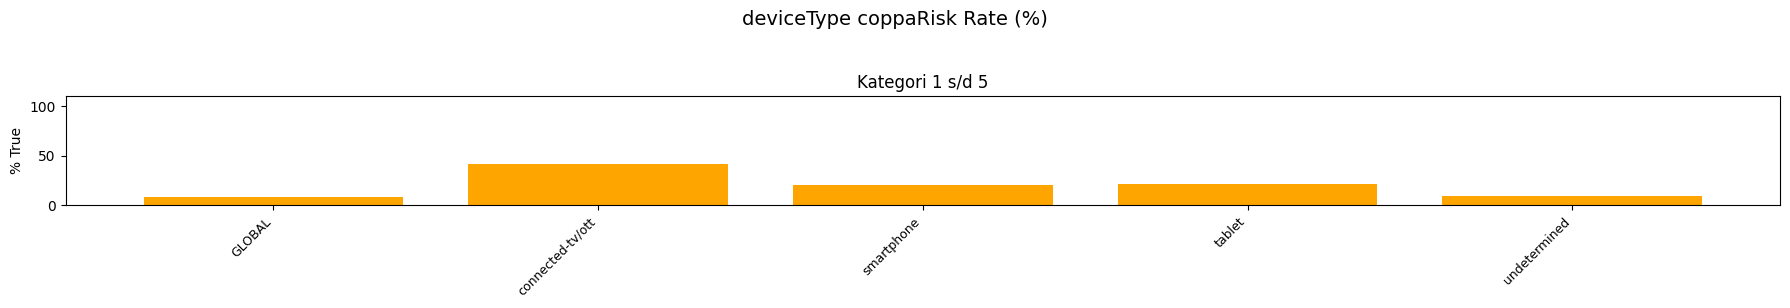

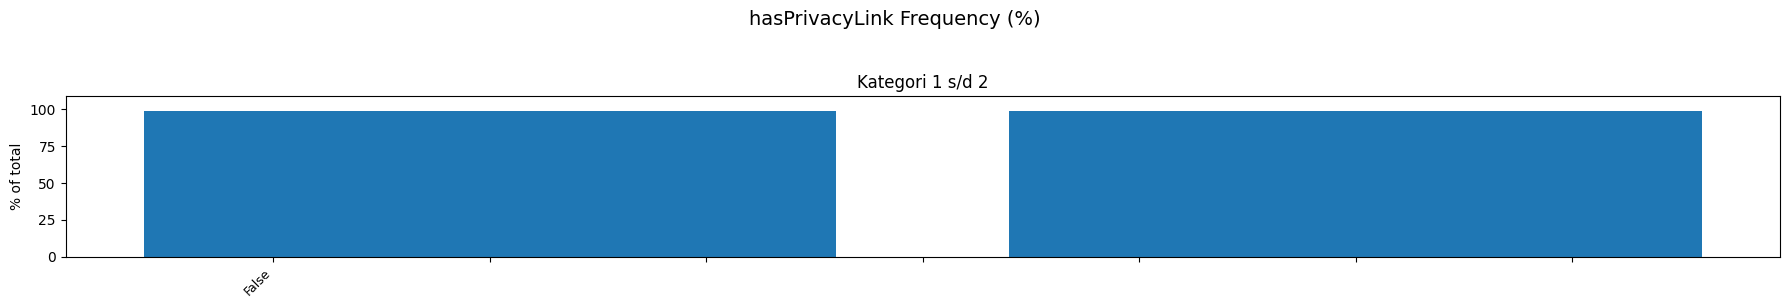

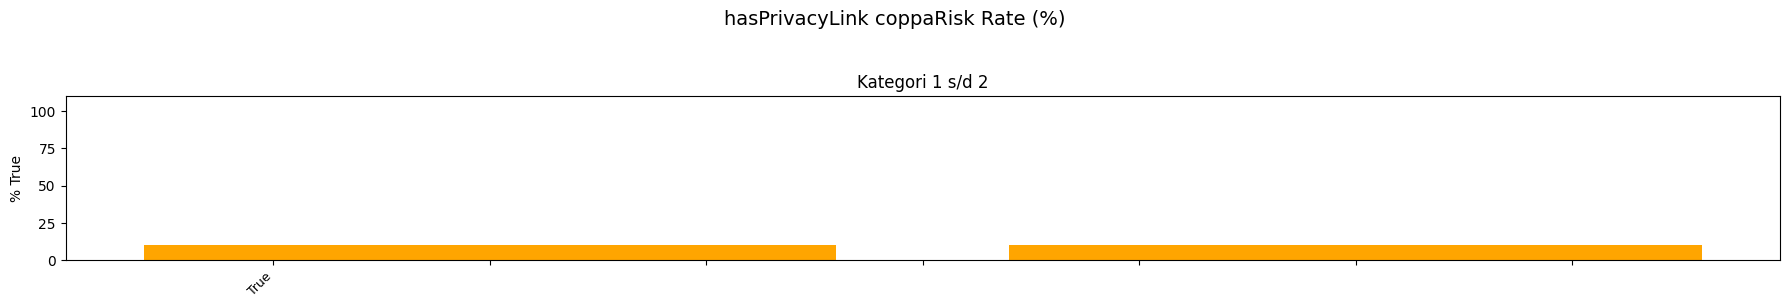

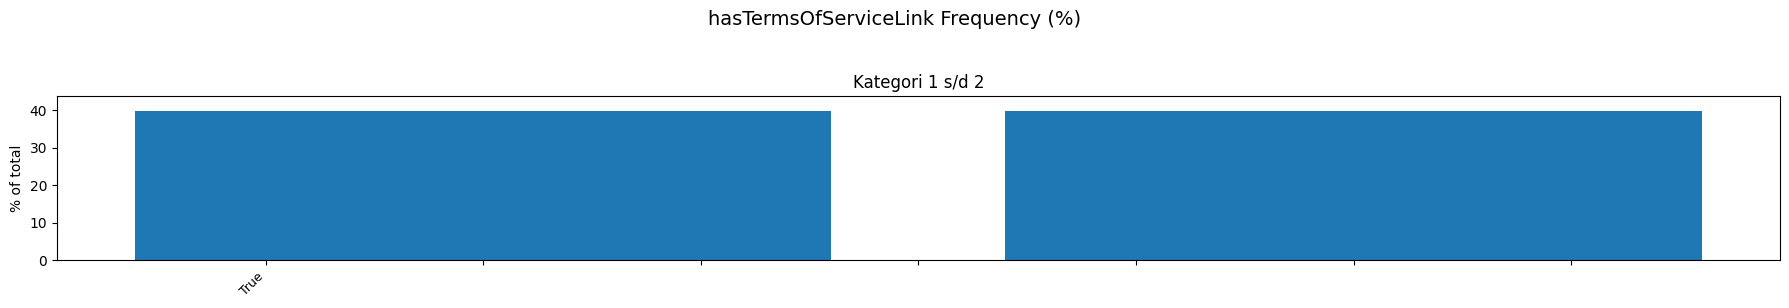

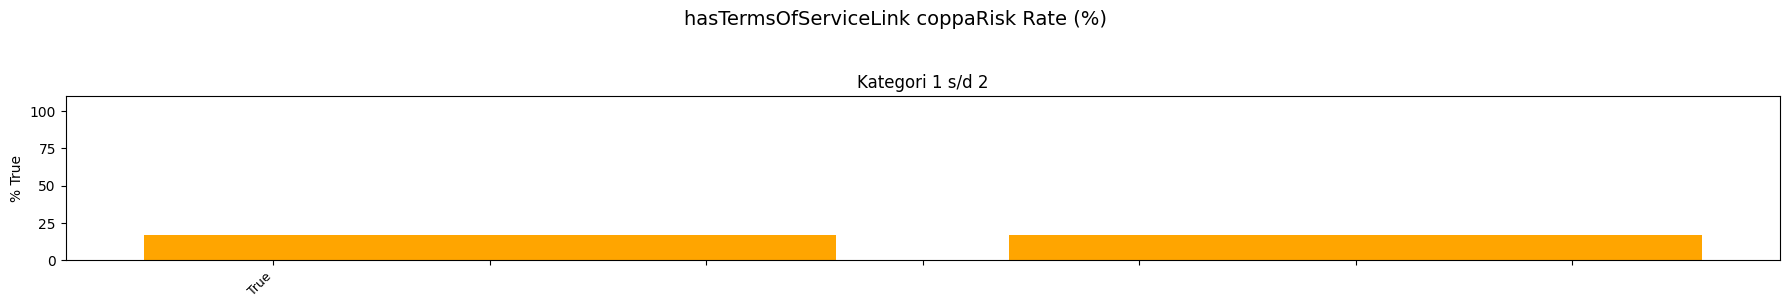

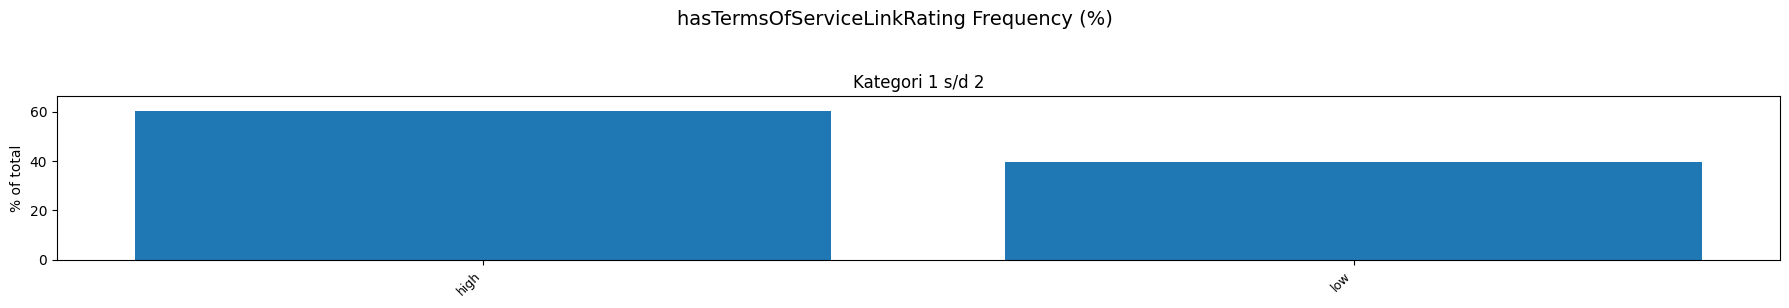

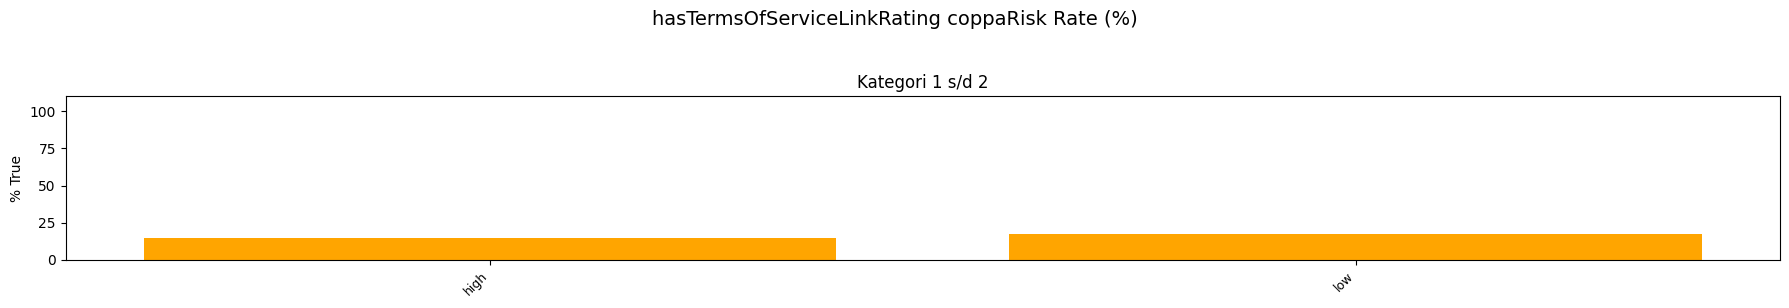

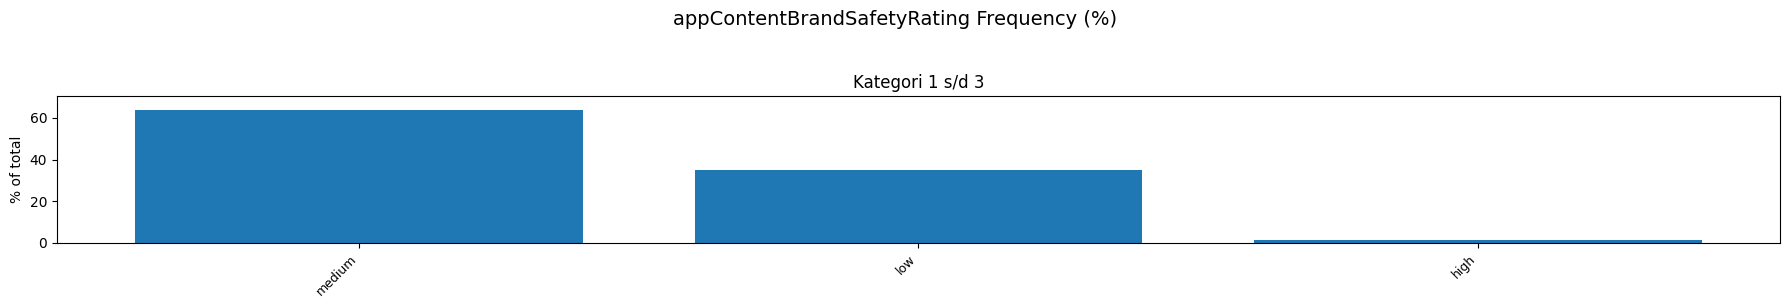

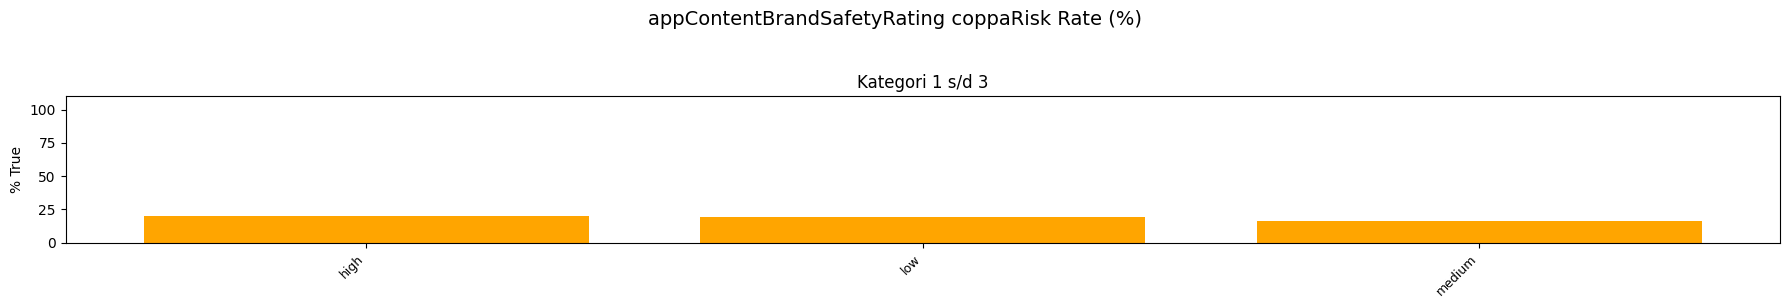

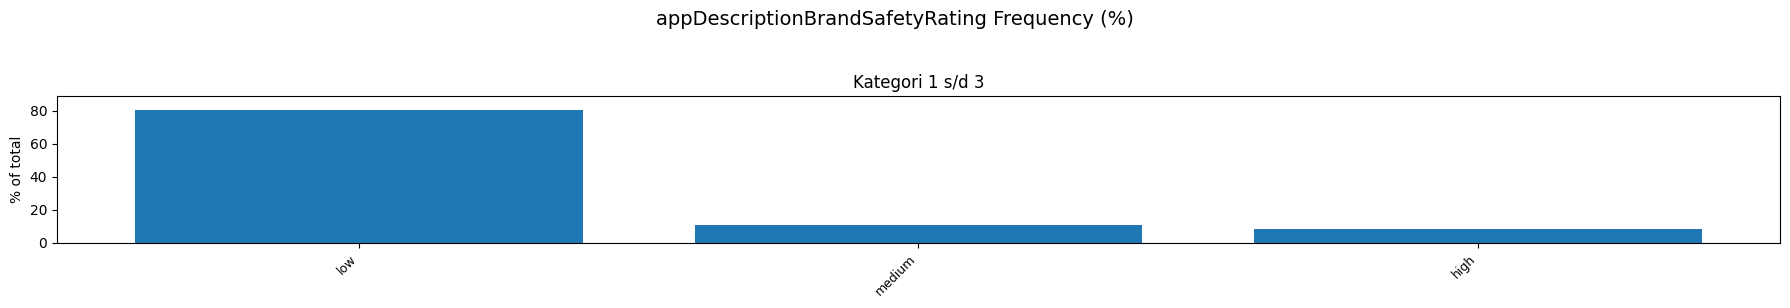

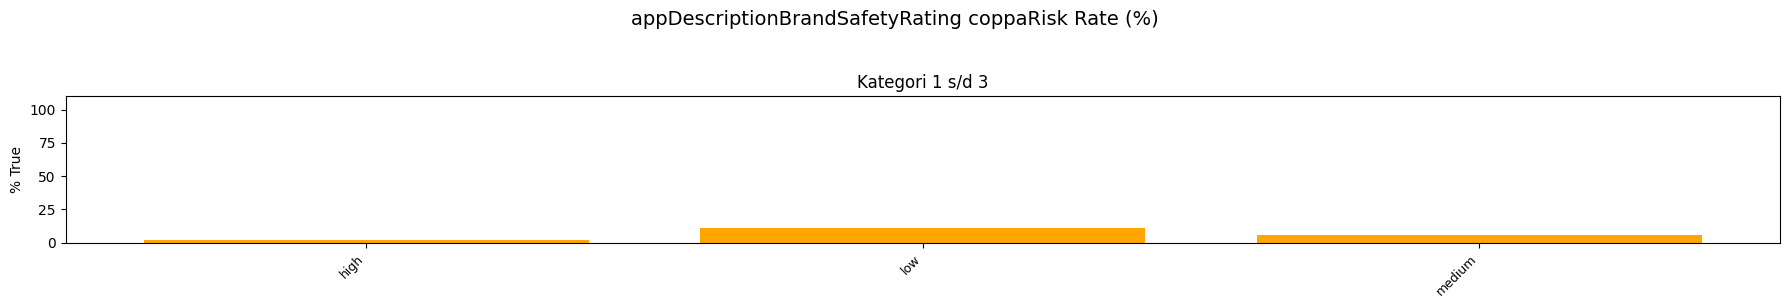

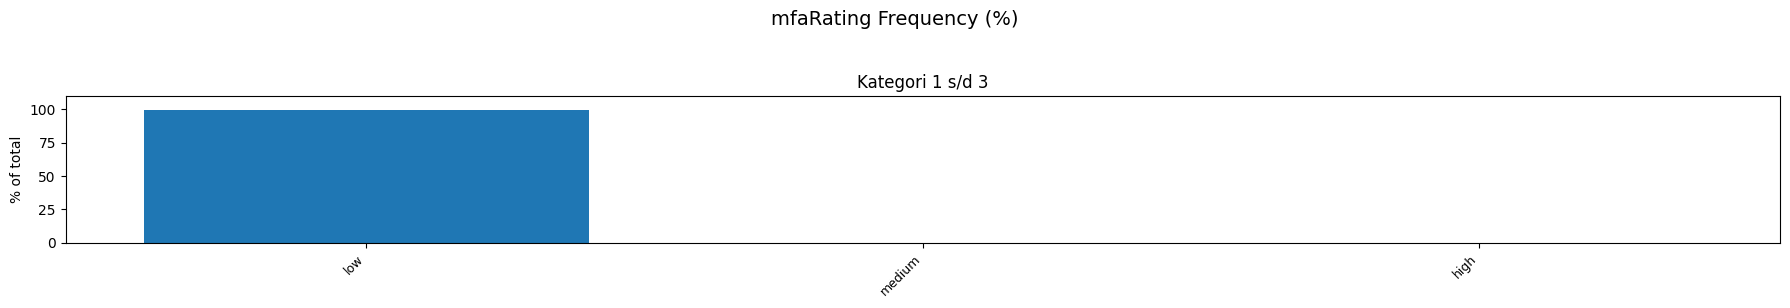

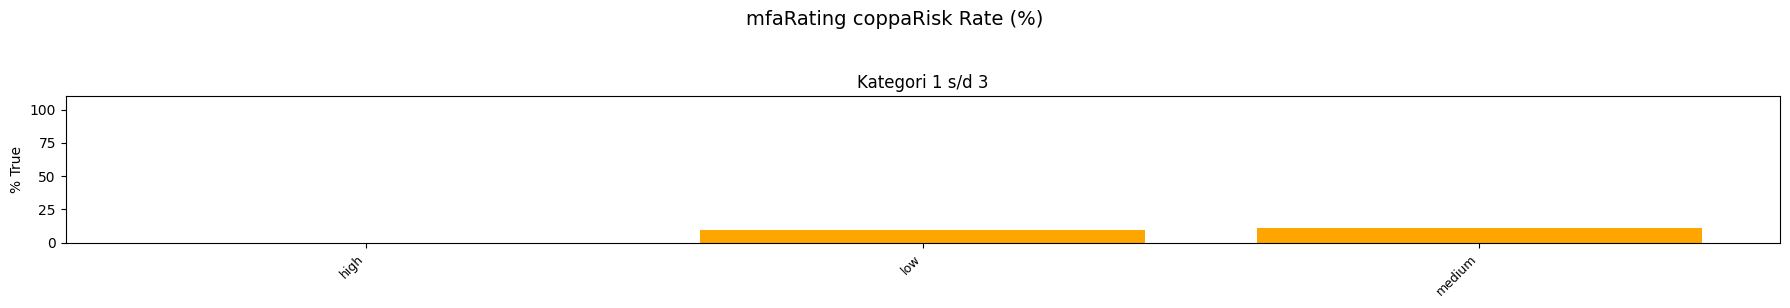

In [151]:
import math

def plot_categorical_distribution_and_target(df, categoricals, n_subplots=6, max_per_subplot=15):
    for col in categoricals:
        # --- Frequency ---
        counts = df[col].value_counts(normalize=True) * 100
        categories = counts.index.tolist()
        n_cats = len(categories)
        n_groups = math.ceil(n_cats / max_per_subplot)
        n_groups = min(n_groups, n_subplots)  # Maksimal 6 subplot

        fig, axs = plt.subplots(n_groups, 1, figsize=(min(18, 3*max_per_subplot), 3*n_groups))
        if n_groups == 1:
            axs = [axs]
        fig.suptitle(f'{col} Frequency (%)', fontsize=14, y=1.01)
        
        for i in range(n_groups):
            start = i * max_per_subplot
            end = min(start + max_per_subplot, n_cats)
            group_cats = categories[start:end]
            group_vals = counts[group_cats]
            axs[i].bar(group_cats, group_vals)
            axs[i].set_ylabel('% of total')
            axs[i].set_ylim(0, group_vals.max()*1.1)
            axs[i].set_xticklabels(group_cats, rotation=45, ha='right', fontsize=9)
            axs[i].set_title(f'Kategori {start+1} s/d {end}')
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        
        # --- coppaRisk Rate ---
        rate = df.groupby(col)['coppaRisk'].mean() * 100
        categories = rate.index.tolist()
        n_cats = len(categories)
        n_groups = math.ceil(n_cats / max_per_subplot)
        n_groups = min(n_groups, n_subplots)

        fig, axs = plt.subplots(n_groups, 1, figsize=(min(18, 3*max_per_subplot), 3*n_groups))
        if n_groups == 1:
            axs = [axs]
        fig.suptitle(f'{col} coppaRisk Rate (%)', fontsize=14, y=1.01)
        
        for i in range(n_groups):
            start = i * max_per_subplot
            end = min(start + max_per_subplot, n_cats)
            group_cats = categories[start:end]
            group_vals = rate[group_cats]
            axs[i].bar(group_cats, group_vals, color='orange')
            axs[i].set_ylabel('% True')
            axs[i].set_ylim(0, 110)
            axs[i].set_xticklabels(group_cats, rotation=45, ha='right', fontsize=9)
            axs[i].set_title(f'Kategori {start+1} s/d {end}')
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.savefig(f'hist_cat_{col}.png')
        plt.show()

# Contoh pemanggilan
plot_categorical_distribution_and_target(pd.concat([train_features, train_labels], axis=1), categoricals)


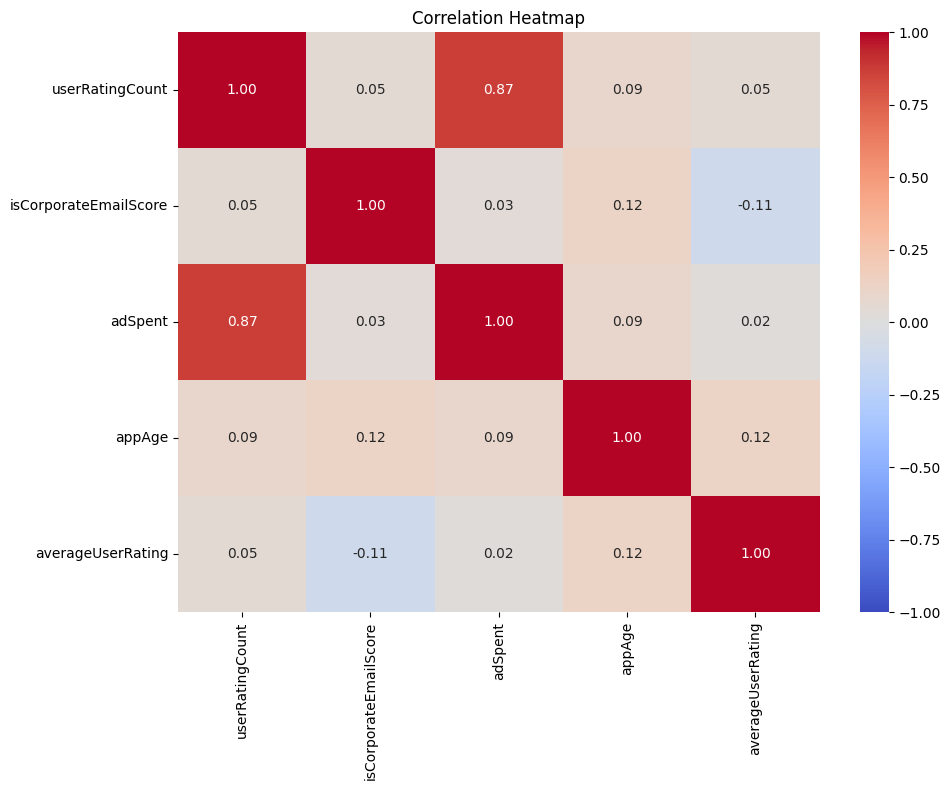

In [152]:
import seaborn as sns

# 5.1 Pairwise Relationships: Correlation Heatmap
corr = train_features[numerics].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1,
            xticklabels=numerics, yticklabels=numerics)
plt.title('Correlation Heatmap')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f'heatmap_num.png')
plt.show()

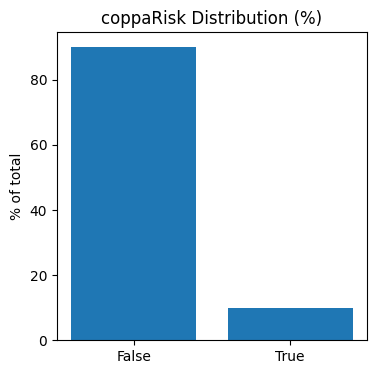

In [153]:
# 6. Target Distribution & Imbalance: Count Plot
counts = train_labels['coppaRisk'].value_counts(normalize=True) * 100
plt.figure(figsize=(4,4))
plt.bar(['False', 'True'], counts.values)
plt.title('coppaRisk Distribution (%)')
plt.ylabel('% of total')
plt.savefig(f'target_dist.png')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math # Import math

# Asumsikan df sudah ada dan categoricals adalah list nama kolom kategori
# Contoh: categoricals = ['developerCountry', 'primaryGenreName', 'countryCode']

def plot_boxplots_subdivided(df, categoricals, n_cols=6, figsize_base_width=30, subplot_height=4):
    """
    Membuat boxplot terpisah dalam subplot untuk setiap kategori dalam kolom.

    Args:
        df (pd.DataFrame): DataFrame sumber.
        categoricals (list): List nama kolom kategorikal yang akan divisualisasikan.
        n_cols (int): Jumlah kolom subplot per baris.
        figsize_base_width (int): Lebar dasar figure (akan disesuaikan).
        subplot_height (int): Tinggi per baris subplot.
    """
    for col in categoricals:
        print(f"--- Plotting for: {col} ---")
        try:
            # 1. Persiapan Data
            data = df[[col, 'coppaRisk']].dropna()
            if data.empty:
                print(f"Skipping {col}: No non-null data found.")
                continue
                
            data['coppaRisk'] = data['coppaRisk'].astype(int) # Pastikan coppaRisk numerik
            categories = sorted(data[col].unique()) # Urutkan kategori
            n_cats = len(categories)

            if n_cats == 0:
                 print(f"Skipping {col}: No unique categories found after dropna.")
                 continue

            # 2. Hitung Dimensi Subplot
            actual_cols = min(n_cols, n_cats) # Kolom tidak boleh lebih banyak dari kategori
            n_rows = math.ceil(n_cats / actual_cols)
            
            # Sesuaikan figsize berdasarkan jumlah baris dan kolom aktual
            figsize = (figsize_base_width, n_rows * subplot_height)

            # 3. Inisialisasi Figure dan Axes
            # squeeze=False memastikan axs selalu 2D array, memudahkan flatten
            fig, axs = plt.subplots(n_rows, actual_cols, figsize=figsize, squeeze=False)
            fig.suptitle(f'coppaRisk Distribution by {col}', y=1.01, fontsize=16) # Sesuaikan y

            # --- Perbaikan Utama: Flatten axs ---
            axs = axs.flatten()

            # 4. Iterasi dan Plotting
            for i, cat in enumerate(categories):
                ax = axs[i] # Akses subplot ke-i

                # Filter data untuk kategori ini
                cat_data = data.loc[data[col] == cat, 'coppaRisk']

                # Pastikan ada data untuk diplot
                if cat_data.empty:
                    ax.text(0.5, 0.5, 'No Data', ha='center', va='center')
                    ax.set_title(f'{cat}\n(No Data)', fontsize=9)
                    ax.set_xticks([])
                    ax.set_yticks([])
                    continue

                # Buat boxplot horizontal
                bp = ax.boxplot(cat_data, vert=False, patch_artist=True, widths=0.6,
                                showfliers=True, # Tampilkan outliers
                                medianprops=dict(color='red', linewidth=1.5),
                                boxprops=dict(facecolor='lightblue', alpha=0.7))

                # Kustomisasi tampilan
                ax.set_title(f'{cat}', fontsize=9, pad=5)
                ax.set_xlim(-0.1, 1.1) # Sesuaikan batas agar lebih pas
                ax.set_xticks([0, 1])
                ax.set_xticklabels(['False', 'True'], fontsize=8)
                ax.set_yticks([]) # Sembunyikan tick y-axis karena tidak informatif di sini
                ax.tick_params(axis='x', which='major', pad=1) # Atur padding tick x

            # 5. Sembunyikan Axes yang Tidak Digunakan
            for j in range(i + 1, len(axs)):
                axs[j].axis('off')

            # 6. Penyesuaian Layout Akhir
            plt.tight_layout(rect=[0, 0, 1, 0.98]) # Sesuaikan rect untuk judul utama
            plt.subplots_adjust(hspace=0.4, wspace=0.3) # Tambah spacing
            plt.savefig(f'boxplot_cat_{col}.png')
            plt.show()

        except Exception as e:
            print(f"Could not plot for column '{col}'. Error: {e}")


# --- Contoh Pemanggilan ---
# Asumsikan 'df' adalah DataFrame Anda dan 'categoricals' adalah list kolom
# Contoh kolom kategorikal dari dataset Anda
categoricals_subset = ['developerCountry','countryCode','primaryGenreName', 'downloads', 'deviceType']

# Panggil fungsi
plot_boxplots_subdivided(pd.concat([train_features, train_labels], axis=1), categoricals_subset, n_cols=6, figsize_base_width=25, subplot_height=3)

In [208]:
## Penanganan Missing Values
# Mengganti string kosong dengan NaN
train_features.replace('', np.nan, inplace=True)
test_features.replace('', np.nan, inplace=True)

In [209]:
# Memeriksa missing values
missing_percentage = train_features.isnull().mean() * 100
print("\nPersentase missing values per kolom:")
print(missing_percentage.sort_values(ascending=False))


Persentase missing values per kolom:
appContentBrandSafetyRating        88.028571
adSpent                            81.128571
hasTermsOfServiceLink              66.214286
hasTermsOfServiceLinkRating        66.214286
downloads                          30.700000
averageUserRating                  17.600000
isCorporateEmailScore              16.114286
hasPrivacyLink                     10.714286
countryCode                         0.914286
appAge                              0.714286
developerCountry                    0.000000
userRatingCount                     0.000000
primaryGenreName                    0.000000
deviceType                          0.000000
appDescriptionBrandSafetyRating     0.000000
mfaRating                           0.000000
dtype: float64


In [210]:
train_idx = train_features.index
test_idx = test_features.index

# Tambahkan label untuk membedakan data pelatihan dan pengujian
train_features['is_train'] = True
test_features['is_train'] = False

# Gabungkan dataset
all_df = pd.concat([train_features, test_features], axis=0)

import pandas as pd

def rare_encoding(series: pd.Series, threshold: float = 0.1, others_label: str = 'others') -> pd.Series:
    # Compute normalized frequency of each category (exclude NaN)
    freq = series.value_counts(normalize=True)
    # Identify rare labels
    rare_labels = freq[freq < threshold].index
    # Map series values to either itself or others_label
    encoded = series.where(~series.isin(rare_labels), other=others_label)
    # Optionally fill NaNs with others_label
    return encoded

cols = ['developerCountry']
for col in cols:
    all_df[col] = rare_encoding(all_df[col], threshold=0.1)

train_features = all_df[all_df['is_train']].drop(columns=['is_train'])
test_features  = all_df[~all_df['is_train']].drop(columns=['is_train'])

# 6. Kembalikan indeks asli
train_features.index = train_idx
test_features.index  = test_idx

In [211]:
# Menghapus fitur dengan missing values lebih dari 30%
threshold = 50
high_missing_cols = missing_percentage[missing_percentage > threshold].index
print(f"\nKolom dengan missing values lebih dari {threshold}%:")
print(high_missing_cols.tolist())


Kolom dengan missing values lebih dari 50%:
['hasTermsOfServiceLink', 'hasTermsOfServiceLinkRating', 'adSpent', 'appContentBrandSafetyRating']


In [212]:
# Menghapus fitur dengan missing values tinggi
train_features_cleaned = train_features.drop(columns=high_missing_cols)
test_features_cleaned = test_features.drop(columns=high_missing_cols)

print("\nUkuran data train setelah menghapus kolom dengan missing values tinggi:", train_features_cleaned.shape)


Ukuran data train setelah menghapus kolom dengan missing values tinggi: (7000, 13)


In [213]:
## Preprocessing Data
# Memeriksa missing values yang tersisa
missing_percentage_after = train_features_cleaned.isnull().mean() * 100
print("\nPersentase missing values per kolom setelah pembersihan:")
print(missing_percentage_after.sort_values(ascending=False))


Persentase missing values per kolom setelah pembersihan:
ID                                 100.000000
downloads                           30.700000
averageUserRating                   17.600000
isCorporateEmailScore               16.114286
hasPrivacyLink                      10.714286
countryCode                          0.914286
appAge                               0.714286
developerCountry                     0.000000
userRatingCount                      0.000000
primaryGenreName                     0.000000
deviceType                           0.000000
appDescriptionBrandSafetyRating      0.000000
mfaRating                            0.000000
dtype: float64


In [214]:
# 1) Gabungkan train & test untuk perhitungan
combined = pd.concat(
    [train_features_cleaned, test_features_cleaned],
    axis=0,
    ignore_index=True
)

# 2) Hitung median untuk numeric dan mode untuk categorical dari 'combined' dan simpan dalam dict agar bisa pakai ulang
median_values = {}
for col in combined.select_dtypes(include=['int64', 'float64']).columns:
    if col != 'ID':
        median_values[col] = combined[col].median()

mode_values = {}
for col in combined.select_dtypes(include=['object', 'category']).columns:
    # .mode() bisa menghasilkan Series, ambil elemen pertama
    if col != 'ID':
        mode_values[col] = combined[col].mode()[0]

In [215]:
# (C) Jika masih perlu fill satu per satu, pakai .loc:
for col, med in median_values.items():
    train_features_cleaned.loc[:, col] = train_features_cleaned.loc[:, col].fillna(med)
    test_features_cleaned.loc[:, col]  = test_features_cleaned.loc[:, col].fillna(med)

for col, mod in mode_values.items():
    train_features_cleaned.loc[:, col] = train_features_cleaned.loc[:, col].fillna(mod)
    test_features_cleaned.loc[:, col]  = test_features_cleaned.loc[:, col].fillna(mod)

# (D) Normalisasi tipe object setelah fillna (jika muncul warning downcasting)
train_features_cleaned = train_features_cleaned.infer_objects(copy=False)
test_features_cleaned  = test_features_cleaned.infer_objects(copy=False)

In [216]:
from sklearn.preprocessing import LabelEncoder
categorical_cols = train_features_cleaned.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    le = LabelEncoder()
    # Gabungkan, lalu paksa jadi string
    combined = pd.concat(
        [train_features_cleaned[col], test_features_cleaned[col]],
        axis=0
    ).astype(str)

    le.fit(combined)  # kelas diambil dari 'combined' yang sudah seragam
    train_features_cleaned[col] = le.transform(train_features_cleaned[col].astype(str))
    test_features_cleaned[col]  = le.transform(test_features_cleaned[col].astype(str))

In [217]:
# saya telah menggabungkan kode anda dengan kode saya terkait modellung tapi ada error yang muncul

# kode anda:

# ----------------------------------------
# 1) UTILITAS DARI KODE1 (ColumnSchema, PrimitiveBase, AggregationPrimitive)
# ----------------------------------------

# --- DuplicateTagsWarning & StandardTagsChangedWarning ---
class DuplicateTagsWarning(UserWarning):
    def get_warning_message(self, duplicate_tags, name):
        return f"Semantic tag(s) '{', '.join(duplicate_tags)}' already present on column '{name}'"

class StandardTagsChangedWarning(UserWarning):
    def get_warning_message(self, use_standard_tags, col_name=None):
        changed = "added to" if use_standard_tags else "removed from"
        name = (f'"{col_name}"') if col_name is not None else "your column"
        return f"Standard tags have been {changed} {name}"

# --- _convert_input_to_set + helper validation ---
def _validate_tags_input_type(semantic_tags, error_language):
    if type(semantic_tags) not in (list, set, str):
        raise TypeError(f"{error_language} must be a string, set or list")

def _validate_string_tags(semantic_tags, error_language):
    if not all(isinstance(tag, str) for tag in semantic_tags):
        raise TypeError(f"{error_language} must contain only strings")

def _convert_input_to_set(semantic_tags, error_language="semantic_tags", validate=True):
    if not semantic_tags:
        return set()
    if validate:
        _validate_tags_input_type(semantic_tags, error_language)
    if isinstance(semantic_tags, str):
        return {semantic_tags}
    if isinstance(semantic_tags, list):
        semantic_tags = set(semantic_tags)
    if validate:
        _validate_string_tags(semantic_tags, error_language)
    return semantic_tags

# --- ColumnSchema (dipangkas untuk fokus ke semantic_tags & logical_type) ---
class ColumnSchema:
    def __init__(
        self,
        logical_type=None,
        semantic_tags=None,
        use_standard_tags=False,
    ):
        from woodwork.logical_types import Boolean, BooleanNullable, Datetime, LatLong, NaturalLanguage, Ordinal, Unknown
        # simpan
        self.logical_type = logical_type() if isclass(logical_type) else logical_type
        self.use_standard_tags = use_standard_tags
        # bangun semantic_tags
        tags = _convert_input_to_set(semantic_tags, validate=True)
        if self.use_standard_tags and self.logical_type is not None:
            tags = tags.union(self.logical_type.standard_tags)
        self.semantic_tags = tags

# --- convert_to_nth (diperlukan di PrimitiveBase) ---
def convert_to_nth(integer):
    string_nth = str(integer)
    end_int = integer % 10
    if end_int == 1 and integer % 100 != 11:
        return f"{integer}st"
    elif end_int == 2 and integer % 100 != 12:
        return f"{integer}nd"
    elif end_int == 3 and integer % 100 != 13:
        return f"{integer}rd"
    else:
        return f"{integer}th"

# --- PrimitiveBase & AggregationPrimitive ---
class PrimitiveBase:
    name = None
    input_types = None
    return_type = None
    default_value = np.nan
    number_output_features = 1
    description_template = None

    def __call__(self, arg_series):
        # terima list/array, bungkus jadi Series
        s = pd.Series(arg_series)
        func = getattr(self, "_method", None) or self.get_function()
        # cache fungsi
        self._method = func
        return func(s)

    def get_function(self):
        raise NotImplementedError

    def get_args_string(self):
        args = []
        for n, v in zip(self.__class__.__init__.__defaults__ or [], []):
            pass
        return ""

class AggregationPrimitive(PrimitiveBase):
    def generate_name(self, col_name, agg_name):
        return f"{agg_name.upper()}({col_name})"

# ----------------------------------------
# 2) AGGREGATION PRIMITIVES: Count, Min, Max
# ----------------------------------------
class Count(AggregationPrimitive):
    name = "count"
    def get_function(self):
        return pd.Series.count

class Min(AggregationPrimitive):
    name = "min"
    def get_function(self):
        return np.min

class Max(AggregationPrimitive):
    name = "max"
    def get_function(self):
        return np.max

class Mean(AggregationPrimitive):
    name = "mean"
    def get_function(self):
        return np.mean

class Sum(AggregationPrimitive):
    name = "mean"
    def get_function(self):
        return np.sum

class Std(AggregationPrimitive):
    name = "std"
    def get_function(self):
        return np.std


# ----------------------------------------
# 3) LOAD & SIAPKAN DATA
# ----------------------------------------
# 1) Siapkan data
train_df = train_features_cleaned.copy()
test_df = test_features_cleaned.copy()
target_df = pd.read_csv('/kaggle/input/target.csv',
                        header=None, names=['coppaRisk'])
train_df['coppaRisk'] = target_df['coppaRisk']

numeric_cols = train_df.select_dtypes(include=[np.number]).columns

# 2) Genre
group_col = 'primaryGenreName'
agg_dict = {}
for col in numeric_cols:
    agg_dict[f"{group_col.upper()}_MAX_{col}"]   = (col, lambda s, f=Max():   f(s))
    agg_dict[f"{group_col.upper()}_MIN_{col}"]   = (col, lambda s, f=Min():   f(s))
    agg_dict[f"{group_col.upper()}_COUNT_{col}"] = (col, lambda s, f=Count(): f(s))
    agg_dict[f"{group_col.upper()}_SUM_{col}"] = (col, lambda s, f=Sum(): f(s))
    agg_dict[f"{group_col.upper()}_MEAN_{col}"] = (col, lambda s, f=Mean(): f(s))
    agg_dict[f"{group_col.upper()}_STD_{col}"] = (col, lambda s, f=Std(): f(s))

genre_feats = (
    train_df
      .groupby(group_col)
      .agg(**agg_dict)
      .reset_index()
)

# 3) Content Rating
group_col2 = 'appDescriptionBrandSafetyRating'
agg_dict = {}
for col in numeric_cols:
    agg_dict[f"{group_col2.upper()}_MAX_{col}"]   = (col, lambda s, f=Max():   f(s))
    agg_dict[f"{group_col2.upper()}_MIN_{col}"]   = (col, lambda s, f=Min():   f(s))
    agg_dict[f"{group_col2.upper()}_COUNT_{col}"] = (col, lambda s, f=Count(): f(s))
    agg_dict[f"{group_col2.upper()}_SUM_{col}"] = (col, lambda s, f=Sum(): f(s))
    agg_dict[f"{group_col2.upper()}_MEAN_{col}"] = (col, lambda s, f=Mean(): f(s))
    agg_dict[f"{group_col2.upper()}_STD_{col}"] = (col, lambda s, f=Std(): f(s))

content_feats = (
    train_df
      .groupby(group_col2)
      .agg(**agg_dict)
      .reset_index()
)

# 4) Merge & simpan
df = (
    train_df
      .merge(genre_feats,   on=group_col,  how='left')
      .merge(content_feats, on=group_col2, how='left')
      .reset_index(drop=True)
)

print(f"Created {df.shape[1]} features, {df.shape[0]} rows")
df.to_csv('new_feature_matrix_no_ft.csv', index=False)

# Calculate content rating aggregations using the training data
content_feats = (
    train_df
      .groupby(group_col2)
      .agg(**agg_dict)
      .reset_index()
)

# 4) Merge aggregated features with test data
test_df_with_aggs = (
    test_df
      .merge(genre_feats, on=group_col, how='left')
      .merge(content_feats, on=group_col2, how='left')
      .reset_index(drop=True)
)

print(f"Created test feature matrix with {test_df_with_aggs.shape[1]} features, {test_df_with_aggs.shape[0]} rows")
test_df_with_aggs.to_csv('test_feature_matrix_with_aggs.csv', index=False)

# 5) Replace original test_features_cleaned with the enhanced version for prediction
test_features_cleaned = test_df_with_aggs

Created 158 features, 7000 rows
Created test feature matrix with 157 features, 3000 rows


In [218]:
def remove_low_information_features(feature_matrix, features=None):
    keep = [
        c
        for c in feature_matrix
        if (
            feature_matrix[c].nunique(dropna=False) > 1
            and feature_matrix[c].dropna().shape[0] > 0
        )
    ]
    feature_matrix = feature_matrix[keep]
    if features is not None:
        features = [f for f in features if f.get_name() in feature_matrix.columns]
        return feature_matrix, features
    return feature_matrix


def remove_highly_null_features(feature_matrix, features=None, pct_null_threshold=0.95):
    if pct_null_threshold < 0 or pct_null_threshold > 1:
        raise ValueError(
            "pct_null_threshold must be a float between 0 and 1, inclusive.",
        )

    percent_null_by_col = (feature_matrix.isnull().mean()).to_dict()

    if pct_null_threshold == 0.0:
        keep = [
            f_name
            for f_name, pct_null in percent_null_by_col.items()
            if pct_null <= pct_null_threshold
        ]
    else:
        keep = [
            f_name
            for f_name, pct_null in percent_null_by_col.items()
            if pct_null < pct_null_threshold
        ]

    return _apply_feature_selection(keep, feature_matrix, features)


def remove_single_value_features(
    feature_matrix,
    features=None,
    count_nan_as_value=False,
):
    unique_counts_by_col = feature_matrix.nunique(
        dropna=not count_nan_as_value,
    ).to_dict()

    keep = [
        f_name
        for f_name, unique_count in unique_counts_by_col.items()
        if unique_count > 1
    ]
    return _apply_feature_selection(keep, feature_matrix, features)


def remove_highly_correlated_features(
    feature_matrix,
    features=None,
    pct_corr_threshold=0.95,
    features_to_check=None,
    features_to_keep=None,
):
    if feature_matrix.ww.schema is None:
        feature_matrix.ww.init()

    if pct_corr_threshold < 0 or pct_corr_threshold > 1:
        raise ValueError(
            "pct_corr_threshold must be a float between 0 and 1, inclusive.",
        )

    if features_to_check is None:
        features_to_check = list(feature_matrix.columns)
    else:
        for f_name in features_to_check:
            assert (
                f_name in feature_matrix.columns
            ), "feature named {} is not in feature matrix".format(f_name)

    if features_to_keep is None:
        features_to_keep = []

    to_select = ["numeric", Boolean, BooleanNullable]
    fm = feature_matrix.ww[features_to_check]
    fm_to_check = fm.ww.select(include=to_select)

    dropped = set()
    columns_to_check = fm_to_check.columns
    # When two features are found to be highly correlated,
    # we drop the more complex feature
    # Columns produced later in dfs are more complex
    for i in range(len(columns_to_check) - 1, 0, -1):
        more_complex_name = columns_to_check[i]
        more_complex_col = fm_to_check[more_complex_name]

        # Convert boolean or Int64 column to be float64
        if pd.api.types.is_bool_dtype(more_complex_col) or isinstance(
            more_complex_col.dtype,
            pd.Int64Dtype,
        ):
            more_complex_col = more_complex_col.astype("float64")

        for j in range(i - 1, -1, -1):
            less_complex_name = columns_to_check[j]
            less_complex_col = fm_to_check[less_complex_name]

            # Convert boolean or Int64 column to be float64
            if pd.api.types.is_bool_dtype(less_complex_col) or isinstance(
                less_complex_col.dtype,
                pd.Int64Dtype,
            ):
                less_complex_col = less_complex_col.astype("float64")

            if abs(more_complex_col.corr(less_complex_col)) >= pct_corr_threshold:
                dropped.add(more_complex_name)
                break

    keep = [
        f_name
        for f_name in feature_matrix.columns
        if (f_name in features_to_keep or f_name not in dropped)
    ]
    return _apply_feature_selection(keep, feature_matrix, features)


def _apply_feature_selection(keep, feature_matrix, features=None):
    new_matrix = feature_matrix[keep]
    new_feature_names = set(new_matrix.columns)

    if features is not None:
        new_features = []
        for f in features:
            if f.number_output_features > 1:
                slices = [
                    f[i]
                    for i in range(f.number_output_features)
                    if f[i].get_name() in new_feature_names
                ]
                if len(slices) == f.number_output_features:
                    new_features.append(f)
                else:
                    new_features.extend(slices)
            else:
                if f.get_name() in new_feature_names:
                    new_features.append(f)

        return new_matrix, new_features
    return new_matrix

# Create feature matrix DataFrame
feature_matrix = pd.DataFrame(df)

# Apply feature selection functions
print("\nRemoving low information features...")
fm1 = remove_low_information_features(feature_matrix)
print("Shape after removing low information features:", fm1.shape)

fm2 = remove_highly_null_features(fm1)
fm3= remove_single_value_features(fm2)
print("\nRemoving highly correlated features...")
fm4 = remove_highly_correlated_features(fm3, pct_corr_threshold=0.95)
print("Shape after removing highly correlated features:", fm4.shape)
print("Final columns:", fm4.columns.tolist())
df = fm4

feature_matrix = pd.DataFrame(test_features_cleaned)

# Apply feature selection functions
print("\nRemoving low information features...")
fm1 = remove_low_information_features(feature_matrix)
print("Shape after removing low information features:", fm1.shape)

fm2 = remove_highly_null_features(fm1)
fm3= remove_single_value_features(fm2)
print("\nRemoving highly correlated features...")
fm4 = remove_highly_correlated_features(fm3, pct_corr_threshold=0.95)
print("Shape after removing highly correlated features:", fm4.shape)
print("Final columns:", fm4.columns.tolist())
test_features_cleaned = fm4



Removing low information features...
Shape after removing low information features: (7000, 129)

Removing highly correlated features...
Shape after removing highly correlated features: (7000, 51)
Final columns: ['developerCountry', 'countryCode', 'userRatingCount', 'primaryGenreName', 'downloads', 'deviceType', 'hasPrivacyLink', 'isCorporateEmailScore', 'appAge', 'averageUserRating', 'appDescriptionBrandSafetyRating', 'mfaRating', 'coppaRisk', 'PRIMARYGENRENAME_MAX_developerCountry', 'PRIMARYGENRENAME_COUNT_developerCountry', 'PRIMARYGENRENAME_MEAN_developerCountry', 'PRIMARYGENRENAME_STD_developerCountry', 'PRIMARYGENRENAME_MAX_countryCode', 'PRIMARYGENRENAME_MIN_countryCode', 'PRIMARYGENRENAME_MEAN_countryCode', 'PRIMARYGENRENAME_MIN_userRatingCount', 'PRIMARYGENRENAME_MEAN_userRatingCount', 'PRIMARYGENRENAME_STD_userRatingCount', 'PRIMARYGENRENAME_MAX_downloads', 'PRIMARYGENRENAME_MIN_downloads', 'PRIMARYGENRENAME_MEAN_downloads', 'PRIMARYGENRENAME_MAX_deviceType', 'PRIMARYGENRENAM

In [219]:
train_labels.value_counts()

coppaRisk
False        6304
True          696
Name: count, dtype: int64

In [220]:
# 1. Konfigurasi GradientBoosting dengan parameter optimal untuk data imbalance
gb_params = {
    'loss': 'log_loss',
    'learning_rate': 0.05,
    'n_estimators': 200,
    'max_depth': 3,
    'min_samples_split': 20,
    'min_samples_leaf': 10,
    'subsample': 0.8,
    'max_features': 'sqrt',
    'random_state': STATE
}

# 2. Implementasi BalancedBagging dengan GradientBoosting
balanced_gb = BalancedBaggingClassifier(
    estimator=GradientBoostingClassifier(**gb_params),
    n_estimators=10,
    sampling_strategy='auto',
    replacement=False,
    random_state=STATE,
    n_jobs=-1
)

STATE = 42
# Inisialisasi model dengan parameter XGB yang sudah kamu pakai
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'learning_rate': 0.05,
    'max_depth': 5,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42
}

 # Use the preprocessed data from the original code
train_df = df.copy()
test_df = test_features_cleaned.copy()
if 'ID' in test_df.columns:
    test_df = test_df.drop(columns=['ID'])
model = XGBClassifier(**xgb_params)

# Siapkan StratifiedKFold dengan 5 split
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

roc_auc_scores = []
X = df
if 'ID' in X.columns:
    X.drop(columns=['ID'])
if 'coppaRisk' in X.columns:
    X = X.drop(columns=['coppaRisk'])
common_cols = train_df.columns.intersection(test_df.columns)

X = X[common_cols]
test_df = test_df[common_cols]
y = train_labels.iloc[:, 0]
xgb_params = {
    'eval_metric': 'auc',
    'learning_rate': 0.05,
    'max_depth': 5,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': STATE,
    'objective': 'binary:logistic',
    'early_stopping_rounds': 100,
    'n_estimators': 1000
}

# LightGBM parameters
lgbm_params = {
    "num_leaves": 105,
    "max_depth": 4,
    "learning_rate": 0.054721480060189925,
    "n_estimators": 831,
    "min_child_samples": 79,
    "subsample": 0.8376648479771541,
    "colsample_bytree": 0.6902719723767108,
    "reg_alpha": 0.01150946474343417,
    "reg_lambda": 0.008427690336849232,
    "random_state": STATE,
    "objective": 'binary',
    "eval_metric": "auc",
    "early_stopping_rounds": 100,
    "verbose": -1
}

# CatBoost parameters
cat_params = {
    "iterations": 694,
    "learning_rate": 0.0225656772593392,
    "depth": 7,
    "l2_leaf_reg": 3.5436556611563206,
    "bootstrap_type": "Bayesian",
    "random_strength": 5.455259188375764e-05,
    "bagging_temperature": 1.7253369586592922,
    "od_type": "IncToDec",
    "od_wait": 41,
    "loss_function": 'Logloss',
    "eval_metric": 'AUC',
    "auto_class_weights": 'Balanced',
    "random_seed": STATE
}

# Initialize models
xgb_model = XGBClassifier(**xgb_params)
lgbm_model = LGBMClassifier(**lgbm_params)
cat_model = CatBoostClassifier(**cat_params)

# Set up cross-validation
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=STATE)

# Initialize arrays for storing meta-features
train_meta_lgbm = np.zeros(len(X))
test_meta_lgbm = np.zeros(len(test_df))

train_meta_xgb = np.zeros(len(X))
test_meta_xgb = np.zeros(len(test_df))

train_meta_cat = np.zeros(len(X))
test_meta_cat = np.zeros(len(test_df))

# Generate out-of-fold predictions for training data and average predictions for test data
print("Training base models and generating meta-features...")
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y), 1):
    print(f"Processing fold {fold}/{n_splits}")
    
    # Split data for this fold
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Train XGBoost
    xgb_model.fit(
        X_train, y_train, 
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    # Train LightGBM
    lgbm_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
    )
    
    # Train CatBoost
    cat_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    # Store out-of-fold predictions
    train_meta_lgbm[val_idx] = lgbm_model.predict_proba(X_val)[:, 1]
    train_meta_xgb[val_idx] = xgb_model.predict_proba(X_val)[:, 1]
    train_meta_cat[val_idx] = cat_model.predict_proba(X_val)[:, 1]
    
    # Make predictions on test data and average across folds
    test_meta_lgbm += lgbm_model.predict_proba(test_df)[:, 1] / n_splits
    test_meta_xgb += xgb_model.predict_proba(test_df)[:, 1] / n_splits
    test_meta_cat += cat_model.predict_proba(test_df)[:, 1] / n_splits

# Create meta-features DataFrames
X_train_meta = pd.DataFrame({
    'lgbm': train_meta_lgbm,
    'xgb': train_meta_xgb,
    'cat': train_meta_cat
})

X_test_meta = pd.DataFrame({
    'lgbm': test_meta_lgbm,
    'xgb': test_meta_xgb,
    'cat': test_meta_cat
})


Training base models and generating meta-features...
Processing fold 1/5
Processing fold 2/5
Processing fold 3/5
Processing fold 4/5
Processing fold 5/5


In [221]:
(X_train.columns)

Index(['developerCountry', 'countryCode', 'userRatingCount',
       'primaryGenreName', 'downloads', 'deviceType', 'hasPrivacyLink',
       'isCorporateEmailScore', 'appAge', 'averageUserRating',
       'appDescriptionBrandSafetyRating', 'mfaRating',
       'PRIMARYGENRENAME_MAX_developerCountry',
       'PRIMARYGENRENAME_COUNT_developerCountry',
       'PRIMARYGENRENAME_MEAN_developerCountry',
       'PRIMARYGENRENAME_STD_developerCountry',
       'PRIMARYGENRENAME_MAX_countryCode', 'PRIMARYGENRENAME_MIN_countryCode',
       'PRIMARYGENRENAME_MEAN_countryCode',
       'PRIMARYGENRENAME_MIN_userRatingCount',
       'PRIMARYGENRENAME_MEAN_userRatingCount',
       'PRIMARYGENRENAME_STD_userRatingCount',
       'PRIMARYGENRENAME_MAX_downloads', 'PRIMARYGENRENAME_MIN_downloads',
       'PRIMARYGENRENAME_MEAN_downloads', 'PRIMARYGENRENAME_MAX_deviceType',
       'PRIMARYGENRENAME_STD_deviceType',
       'PRIMARYGENRENAME_MAX_isCorporateEmailScore',
       'PRIMARYGENRENAME_MEAN_isCorporateE

In [195]:
len(test_df.columns)

49

In [196]:
missing_cols = set(X_train.columns) - set(test_df.columns)
# print("Kolom di train tapi tidak di test:", missing_cols)
print(len(missing_cols))

0


In [222]:
# Train and evaluate meta-model using cross-validation
meta_skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
meta_roc_auc_scores = []

print("\nTraining and evaluating meta-model...")
for fold, (meta_train_idx, meta_val_idx) in enumerate(meta_skf.split(X_train_meta, y), 1):
    # Split meta-features for this fold
    X_meta_train, X_meta_val = X_train_meta.iloc[meta_train_idx], X_train_meta.iloc[meta_val_idx]
    y_meta_train, y_meta_val = y.iloc[meta_train_idx], y.iloc[meta_val_idx]
    
    # Train meta-model (Logistic Regression)
    meta_model = LogisticRegression(random_state=STATE, max_iter=1000)
    meta_model.fit(X_meta_train, y_meta_train)
    
    # Evaluate meta-model
    y_meta_val_proba = meta_model.predict_proba(X_meta_val)[:, 1]
    score = roc_auc_score(y_meta_val, y_meta_val_proba)
    meta_roc_auc_scores.append(score)
    
    print(f"Meta-model Fold {fold} — ROC AUC: {score:.4f}")

# Calculate mean and standard deviation of ROC AUC scores
mean_meta_auc = np.mean(meta_roc_auc_scores)
std_meta_auc = np.std(meta_roc_auc_scores)
print(f"\nMeta-model Mean ROC AUC over 5 folds: {mean_meta_auc:.4f} ± {std_meta_auc:.4f}")

# Train final meta-model on all training data
final_meta_model = LogisticRegression(random_state=STATE, max_iter=1000)
final_meta_model.fit(X_train_meta, y)

# Make final predictions on test data
final_test_predictions_proba = final_meta_model.predict_proba(X_test_meta)[:, 1]


Training and evaluating meta-model...
Meta-model Fold 1 — ROC AUC: 0.8865
Meta-model Fold 2 — ROC AUC: 0.9034
Meta-model Fold 3 — ROC AUC: 0.8976
Meta-model Fold 4 — ROC AUC: 0.8887
Meta-model Fold 5 — ROC AUC: 0.8890

Meta-model Mean ROC AUC over 5 folds: 0.8930 ± 0.0064


In [223]:
# Create submission file
submission = pd.DataFrame({
    'ID': id_test,
    'coppaRisk': final_test_predictions_proba
})

print("\nSample of final submission:")
print(submission.head())



Sample of final submission:
     ID  coppaRisk
0  2807   0.016742
1  1742   0.122678
2   806   0.426437
3  2635   0.022652
4  9047   0.016520


In [224]:
# Save submission file
submission.to_csv('stacking_submission.csv', index=False)
print("\nSubmission file 'stacking_submission.csv' has been created.")


Submission file 'stacking_submission.csv' has been created.



Analyzing feature importance from XGBoost model...


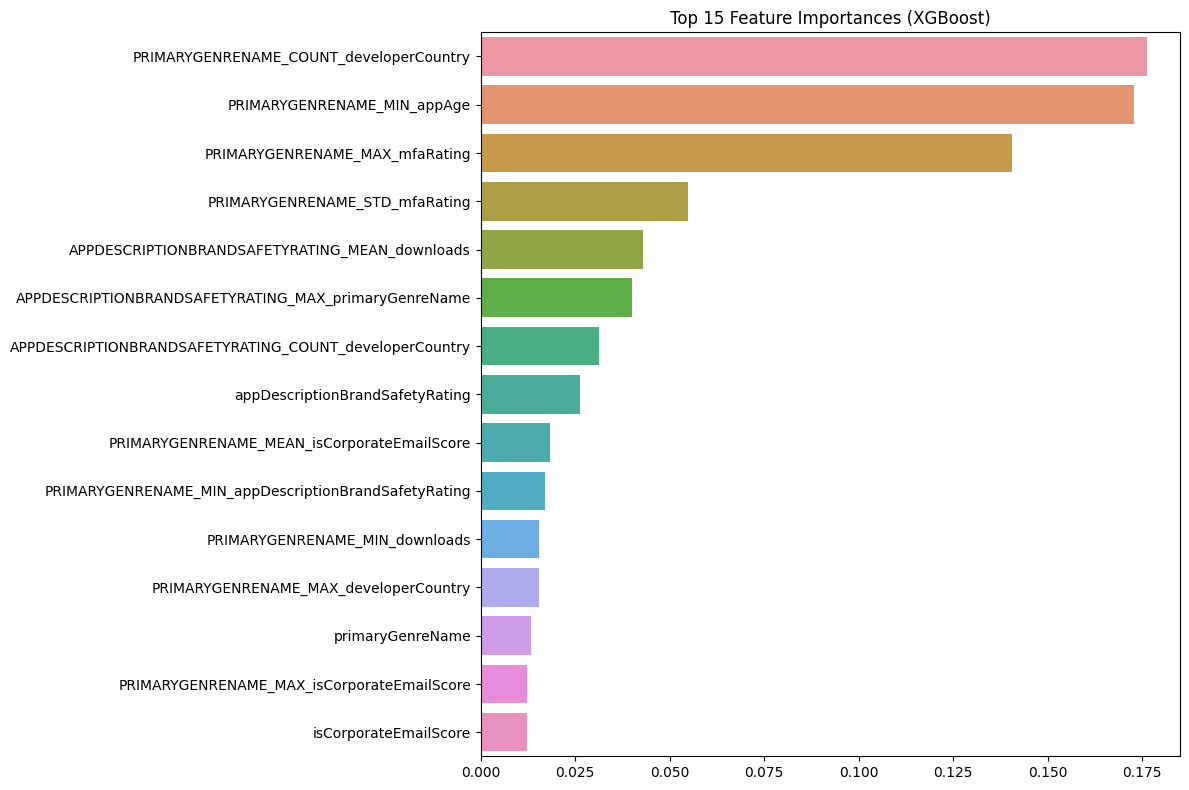

In [225]:
# Feature importance analysis for base models
print("\nAnalyzing feature importance from XGBoost model...")
feature_importance = xgb_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(12, 8))
importances = pd.Series(feature_importance, index=feature_names).sort_values(ascending=False)
sns.barplot(x=importances.values[:15], y=importances.index[:15])
plt.title('Top 15 Feature Importances (XGBoost)')
plt.tight_layout()
plt.show()

In [226]:
 # Print meta-model coefficients
print("\nMeta-model coefficients (importance of each base model):")
meta_coef = pd.Series(final_meta_model.coef_[0], index=X_train_meta.columns)
print(meta_coef.sort_values(ascending=False))


Meta-model coefficients (importance of each base model):
lgbm    4.661252
cat     2.767580
xgb     0.792982
dtype: float64
